<a href="https://colab.research.google.com/github/iliaxant/Pattern_Recognition_HW2/blob/main/HW_2_PR_58545.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2η Εργασία**

## Αναγνώριση Προτύπων - Ακαδημαϊκό έτος 2025-2026

## Ηλίας Ξανθόπουλος 58545

## GitHub Repo: https://github.com/iliaxant/Pattern_Recognition_HW2

---

## **Set-Up**

1) Χειροκίνητο ανέβασμα του αρχείου *Data_exercise1.csv* και του dataset *wine.zip*.

2) Unziping του αρχείου *wine.zip*:

In [ ]:
import zipfile

zip_path = '/content/wine.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

print("Data unzipped successfully to /content directory.")

Data unzipped successfully to /content directory.


3) Εγκατάσταση και φόρτωση των απαραίτητων βιβλιοθηκών:

In [ ]:
!git clone https://github.com/cjlin1/libsvm.git libsvm_folder -q

%cd libsvm_folder/python
!make -s
%cd /content

print("\nSuccessful installation of library 'LINSVM'.")

/content/libsvm_folder/python
/content

Successful installation of library 'LINSVM'.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle
from matplotlib.colors import ListedColormap
import scipy.stats as stats
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import random

sys.path.append("/content/libsvm_folder/python")

from libsvm.svmutil import *

4. Ορισμός seed και αρχικοποίηση του random state machine για reproducibility.

In [ ]:
state = 15

np.random.seed(state)
random.seed(state)

---

## **Άσκηση 1**

Φόρτωση των δεδομένων (*Data_exercise1.csv* αρχείο) και ομαδοποίηση ανά κλάσεις.

In [ ]:
df = pd.read_csv('/content/Data_exercise1.csv', header=None)

w1 = df[df[2] == 1]
w2 = df[df[2] == 2]
w3 = df[df[2] == 3]


print('------- Contents of "data.csv": ------')
print(df)

print('\n-------------- Class 1: -------------')
print(w1)

print('\n-------------- Class 2: -------------')
print(w2)

print('\n-------------- Class 3: -------------')
print(w3)

------- Contents of "data.csv": ------
           0        1  2
0    0.53767  0.84038  1
1    1.83390 -0.88803  1
2   -2.25880  0.10009  1
3    0.86217 -0.54453  1
4    0.31877  0.30352  1
..       ...      ... ..
295  2.39140 -2.11600  3
296  2.26290 -2.81970  3
297  1.25010 -2.44910  3
298  3.91050 -2.31700  3
299  3.86710 -1.82940  3

[300 rows x 3 columns]

-------------- Class 1: -------------
           0        1  2
0   0.537670  0.84038  1
1   1.833900 -0.88803  1
2  -2.258800  0.10009  1
3   0.862170 -0.54453  1
4   0.318770  0.30352  1
..       ...      ... ..
95  0.187330  0.82606  1
96 -0.082494  1.52700  1
97 -1.933000  0.46691  1
98 -0.438970 -0.20971  1
99 -1.794700  0.62519  1

[100 rows x 3 columns]

-------------- Class 2: -------------
           0       1  2
100  3.18320  3.0799  2
101  1.97020  2.0515  2
102  3.94920  3.4115  2
103  3.30710  3.6770  2
104  3.13520  3.8577  2
..       ...     ... ..
195  2.92920  2.7901  2
196  0.51372  1.3011  2
197  3.58120  3.607

Αναπάσταση των δειγμάτων στον χώρο των χαρακτηριστικών.

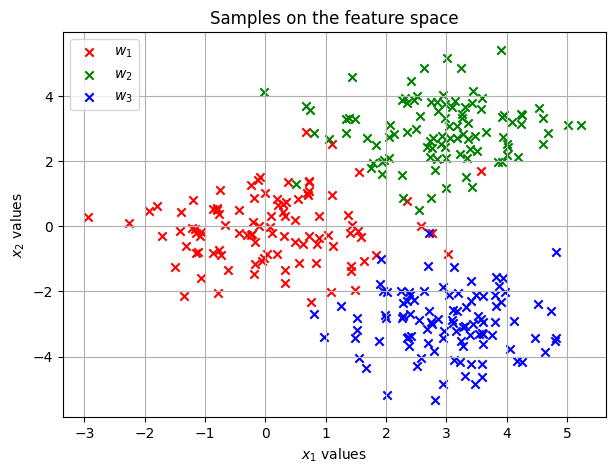

In [ ]:
plt.figure(figsize=(7, 5))

plt.scatter(w1[0], w1[1], color='r', marker='x', label='$w_1$')
plt.scatter(w2[0], w2[1], color='g', marker='x', label='$w_2$')
plt.scatter(w3[0], w3[1], color='b', marker='x', label='$w_3$')

plt.title('Samples on the feature space')
plt.xlabel("$x_1$ values")
plt.ylabel("$x_2$ values")
plt.legend()
plt.grid(True)
plt.show()

### **Α.**

Για την εκτίμηση των pdf $p(x|ω_1)$, $p(x|ω_2)$ και $p(x|ω_3)$ μέσω της μεθόδου παραθύρων Parzen χρησιμοποιείται η συνάρτηση παραθύρου

$φ(x-x_i)=\frac{1}{(2π)^{d/2}}e^{-\frac{||x-x_i||_{L2}^2}{2}}$

και η σχέση $p_N(x)=\frac{1}{N}∑_{i=1}^{N}{\frac{1}{h_N^d}φ(x-x_i)}$

Για $d=2$ (δύο χαρακτηριστικά: $x_1$ και $x_2$) και κανονικοποίηση με $h_N$ έχουμε συνάρτηση παραθύρου

$φ(\frac{x-x_i}{h_N})=\frac{1}{2π}e^{-\frac{||x-x_i||_{L2}^2}{2h_N^2}}$

και pdf

$p_N(x)=\frac{1}{N}∑_{i=1}^{N}{\frac{1}{h_N^2}φ(\frac{x-x_i}{h_N})}$

In [ ]:
def parzen_window(diffs, h_N):

  dist_L2 = np.sum(diffs ** 2, axis = 2)

  return  np.exp(-dist_L2 / (2 * h_N ** 2)) / (2 * np.pi)


In [ ]:
def parzen_pdf(X, x_i, h_N):

  diffs = X[:, np.newaxis, :] - x_i[np.newaxis, :, :]

  phi = parzen_window(diffs, h_N)
  pdf = np.mean(phi, axis=1) / h_N ** 2

  return pdf


Ορισμός συνάρτησης για τον σχεδιασμό γραφικής παράστασης της pdf της κάθε κλάσης στον χώρο των χαρακτηριστικών. Και οι 3 pdf είναι σε κοινά διαγράμματα $̇ $ ένα 2D και ένα 3D με προσανατολισμό (1,1,1).

In [ ]:
def pdf_graph_3D(xx1, xx2, classes_w, class_pdfs, method_param, method=0):

  """
  method == 1 → k-NN  (method_param = k)
  method == 0 (default) → Parzen (method_param = h)
  """

  fig = plt.figure(figsize=(14, 6))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.scatter(classes_w[0][0], classes_w[0][1], color='r', marker='x', label='$w_1$', alpha=0.45)
  ax1.scatter(classes_w[1][0], classes_w[1][1], color='g', marker='x', label='$w_2$', alpha=0.45)
  ax1.scatter(classes_w[2][0], classes_w[2][1], color='b', marker='x', label='$w_3$', alpha=0.45)

  ax1.contour(xx1, xx2, class_pdfs[0], levels=15, cmap = 'Reds')
  ax1.contour(xx1, xx2, class_pdfs[1], levels=15, cmap = 'Greens')
  ax1.contour(xx1, xx2, class_pdfs[2], levels=15, cmap = 'Blues')

  if method:
    ax1.set_title(f"PDFs of all classes (k-NN method, $k$={method_param})")
  else:
    ax1.set_title(f"PDFs of all classes (Parzen Windows method, $h_N$={method_param})")
  ax1.set_xlabel("$x_1$ values")
  ax1.set_ylabel("$x_2$ values")
  ax1.legend()
  ax1.grid(True)


  ax2 = fig.add_subplot(1, 2, 2, projection='3d')
  ax2.plot_surface(xx1, xx2, class_pdfs[0], cmap='Reds', alpha=0.4, linewidth=0, antialiased=True)
  ax2.plot_surface(xx1, xx2, class_pdfs[1], cmap='Greens', alpha=0.4, linewidth=0, antialiased=True)
  ax2.plot_surface(xx1, xx2, class_pdfs[2], cmap='Blues', alpha=0.4, linewidth=0, antialiased=True)

  ax2.scatter(classes_w[0][0], classes_w[0][1], 0, color='r', marker='x', label='$w_1$')
  ax2.scatter(classes_w[1][0], classes_w[1][1], 0, color='g', marker='x', label='$w_2$')
  ax2.scatter(classes_w[2][0], classes_w[2][1], 0, color='b', marker='x', label='$w_3$')

  if method:
    ax2.set_title(f"PDFs of all classes (k-NN method, $k$={method_param}) in (1,1,1) view")
  else:
    ax2.set_title(f"PDFs of all classes (Parzen Windows method, $h_N$={method_param}) in (1,1,1) view")
  ax2.set_xlabel("$x_1$ values")
  ax2.set_ylabel("$x_2$ values")
  ax2.set_zlabel("Propability Density")
  ax2.view_init(elev=30, azim=45)
  ax2.legend()

  plt.show()


Εφαρμογή της μεθόδου παραθύρων Parzen για καθεμία από της κλάσεις σε όλο το πλήθος των δεδομένων του "Data_exercise1.csv" για $h_N=0.3$, $h_N=0.7$ και $h_N=0.1$. Απεικόνιση και των τριών υπολογισμένων pdf μέσω της *pdf_graph_3D* και για τις τρεις τιμές του $h_N$.

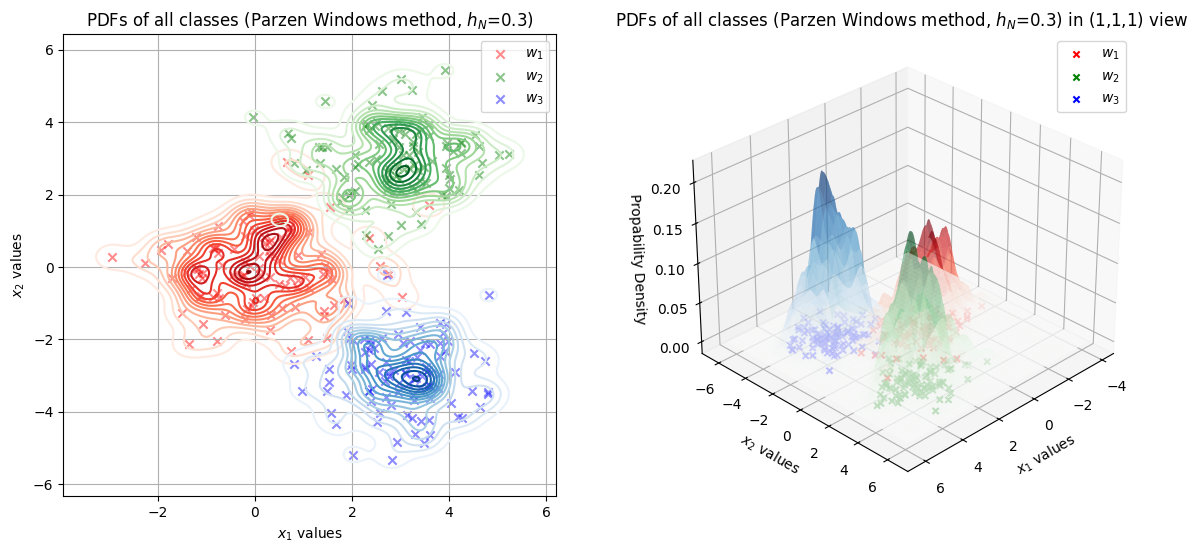

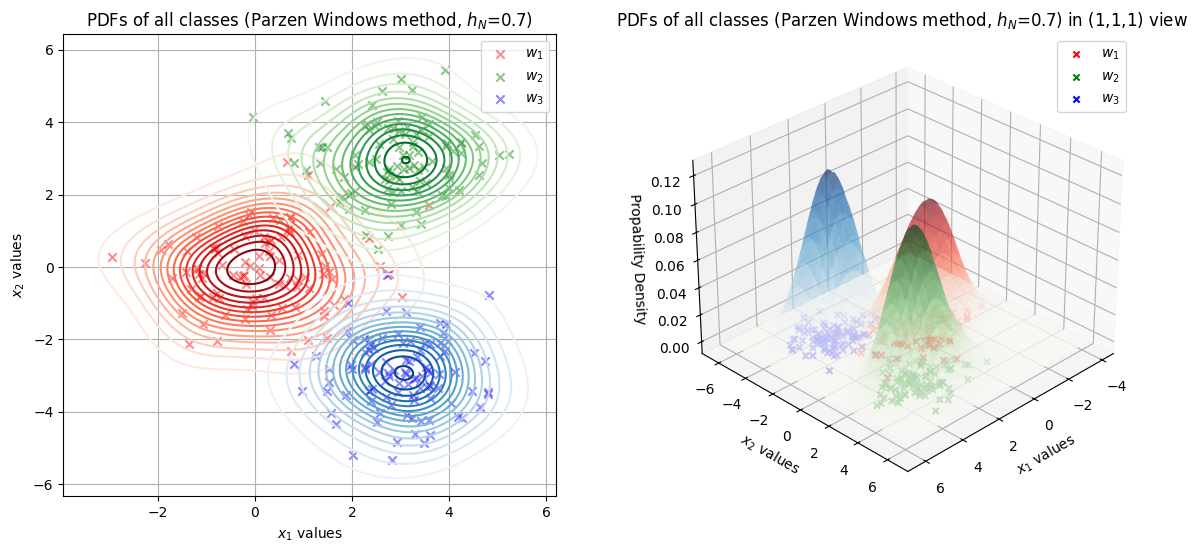

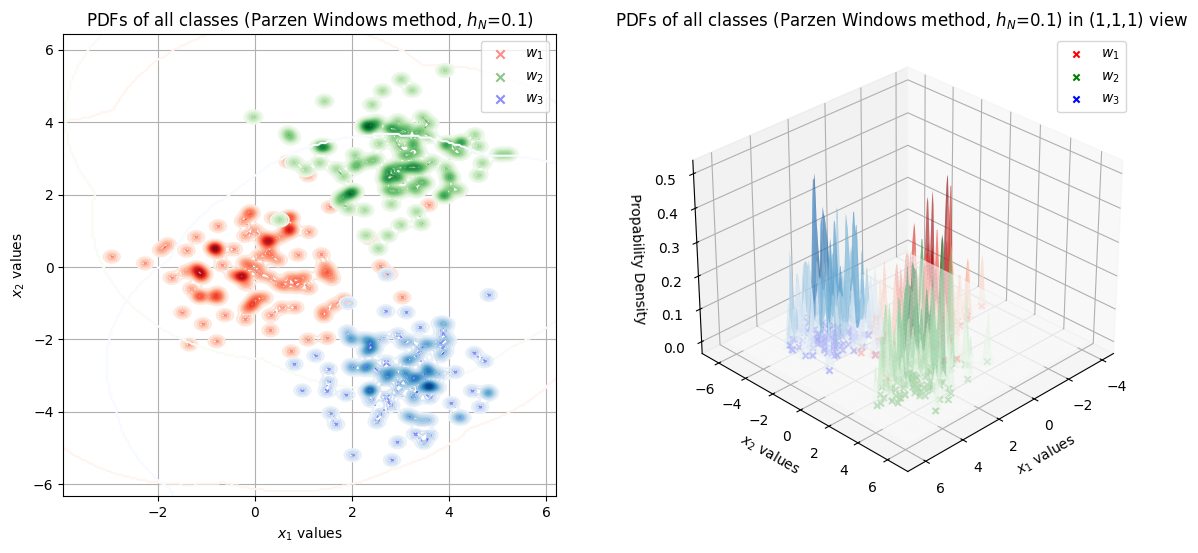

In [ ]:
h_N = [0.3, 0.7, 0.1]

x1 = np.arange(df[0].min()-1, df[0].max()+1, 0.05)
x2 = np.arange(df[1].min()-1, df[1].max()+1, 0.05)

xx1, xx2 = np.meshgrid(x1,x2)
X = np.column_stack((xx1.ravel(), xx2.ravel()))

classes_w = [w1, w2, w3]
class_pdfs=[]            # For saving for later the pdfs calculated with h_N=0.3
for h in h_N:

    p_1 = parzen_pdf(X, w1[[0,1]].to_numpy(), h).reshape(xx1.shape)
    p_2 = parzen_pdf(X, w2[[0,1]].to_numpy(), h).reshape(xx1.shape)
    p_3 = parzen_pdf(X, w3[[0,1]].to_numpy(), h).reshape(xx1.shape)

    if h == h_N[0]:

        class_pdfs.append(p_1)
        class_pdfs.append(p_2)
        class_pdfs.append(p_3)

    pdf_graph_3D(xx1, xx2, classes_w, [p_1, p_2, p_3], h, 0)


Για κάθε μια από τις τιμές του $h_N$ (τιμή standard deviation) παρατηρούμε μέσω των διαγραμμάτων διαφορετικά επίπεδα προσαρμογής των κανονικών κατανομών στα δεδομένα. Πιο συγκεκριμένα:

*   Για $h_N=0.7$ παρατηρείται ότι η τελική pdf της κάθε κλάσης αδυνατεί να "αγκαλιάσει" σωστά τα δεδομένα. Η τελική pdf καταλαμβάνει όπως θα έπρεπε την περιοχή στην οποία είναι διασκορπισμένα τα δείγματα της, με την κορυφή της να είναι στο κέντρο του cluster, αλλά δεν διαθέτει τα τοπικά μέγιστα και τις ιδιομορφίες που προκαλούν τα διασκορπισμένα δειγματα. Με λίγα λόγια παρατηρείται underfitting της τελικής επιφάνειας στα δεδομένα. Αυτό οφείλεται στο ότι η τυπική απόκλιση $h_N$ των συστατικών κανονικών κατανομών (καθεμία με κέντρο ένα από τα δείγματα) είναι τόσο μεγάλη, ωστέ να αλληλοεπικαλύπτονται υπερβολικά και έτσι η υπέρθεση τους να μην διαθέτει ιδιαίτερα χαρακτηριστικά, όπως κορυφές.

*   Για $h_N=0.1$ η τελική επιφάνεια της pdf της κάθε κλάσης "αγκαλιάζει" τα δείγματα σε υπερβολικό βαθμό. Δηλαδή, αντί να υπάρχει μια επιφάνεια με κάποιες εντός ορίων ιδιομορφίες, δημιουργείται μια pdf η οποία στην θέση του κάθε δείγματος χαρακτηρίζεται από μία ψηλή και πολύ απότομη κορυφή. Αυτό είναι το λεγόμενο overfitting, δηλαδή υπερπροσαρμογή της επιφάνειας στα δεδομένα και προκαλείται επειδή η τυπική απόκλιση $h_N$ είναι τόσο μικρή, ώστε οι συνιστώσες κανονικές κατανομές να μην αλληλοεπικαλύπτονται καθόλου και άρα η υπέρθεση τους να είναι απλώς όλες οι κανονικές κατανομές διαχωρισμένες.  

*   Η εφαρμογή της μεθόδου με $h_N=0.3$ βρίσκεται αναμέσα στις δύο παραπάνω περιπτώσεις προσφέροντας μια επιφάνεια που ακολουθεί αρκετά καλά τα δεδομένα, έτσι ώστε να χαρακτηρίζεται από τις ιδιομορφίες που δεν διαθέτει μια underfitted επιφάνεια αλλά και ταυτόχρονα να μην υπάρχουν οι αποτόμες και απομονωμένες κορυφές του overfitting.

Επιλογή με τυχαίο τρόπο του 25% του συνολικού dataset (stratified, δηλαδή 25% από κάθε κλάση) για την εκ νέου εφαρμογή της μεθόδου παραθύρων Parzen.

In [ ]:
data_percentage = 0.25         # Percentage of data to keep

w1_size = int(w1.shape[0] * data_percentage)
w2_size = int(w2.shape[0] * data_percentage)
w3_size = int(w3.shape[0] * data_percentage)

w1_reduced = shuffle(w1, random_state=state, n_samples=w1_size)
w2_reduced = shuffle(w2, random_state=state, n_samples=w2_size)
w3_reduced = shuffle(w3, random_state=state, n_samples=w3_size)


print('\n-------------- Randomly Reduced Class 1: -------------')
print(w1_reduced)

print('\n-------------- Randomly Reduced Class 2: -------------')
print(w2_reduced)

print('\n-------------- Randomly Reduced Class 3: -------------')
print(w3_reduced)


-------------- Randomly Reduced Class 1: -------------
           0         1  2
84 -0.804470  0.552780  1
36  0.325190 -1.333700  1
57  0.371380  1.351400  1
51  0.077359 -0.020028  1
46 -0.164880 -1.156400  1
78 -0.177380 -0.476150  1
93  2.585500  0.023046  1
14  0.714740  0.960950  1
11  3.034900 -0.839590  1
59  1.117400 -0.589030  1
61  0.032557 -0.847930  1
38  1.370300  0.350180  1
21 -1.207500  0.825220  1
90 -1.148000 -0.195220  1
8   3.578400  1.711900  1
25  1.034700 -0.272470  1
63  1.100600  2.526000  1
9   2.769400 -0.194120  1
94 -0.666890  0.051290  1
97 -1.933000  0.466910  1
99 -1.794700  0.625190  1
3   0.862170 -0.544530  1
20  0.671500  2.908000  1
55  1.532600 -0.133220  1
6  -0.433590  0.489970  1

-------------- Randomly Reduced Class 2: -------------
           0        1  2
184  3.92980  1.96400  2
136  3.01250  5.17780  2
157  0.74165  3.56320  2
151  2.96920  3.32320  2
146  2.91550  2.51910  2
178  3.00000  1.16410  2
193  3.86170  1.97430  2
114  2.28800

Αναπάρασταση των επιλεγμένων δειγμάτων στον χώρο των χαρακτηριστικών.

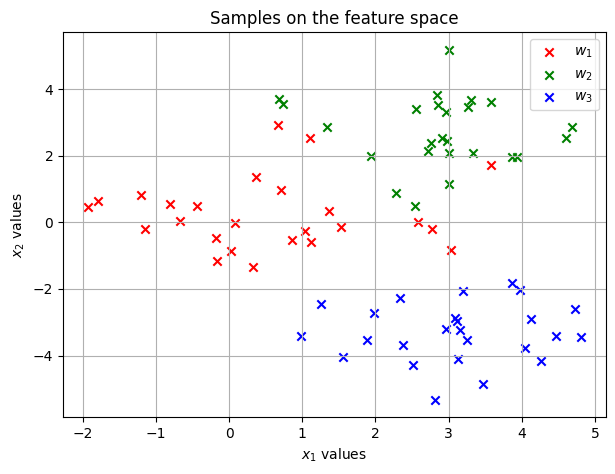

In [ ]:
plt.figure(figsize=(7, 5))

plt.scatter(w1_reduced[0], w1_reduced[1], color='r', marker='x', label='$w_1$')
plt.scatter(w2_reduced[0], w2_reduced[1], color='g', marker='x', label='$w_2$')
plt.scatter(w3_reduced[0], w3_reduced[1], color='b', marker='x', label='$w_3$')

plt.title('Samples on the feature space')
plt.xlabel("$x_1$ values")
plt.ylabel("$x_2$ values")
plt.legend()
plt.grid(True)
plt.show()

Όπως φαίνεται μετά την εκτέλση του επόμενου code block, η εφαρμογή της μεθόδου παραθύρων Parzen με $h_N=0.3$ πάνω στο 25% του αρχικού dataset οδηγεί χειρότερα αποτελέσματα. Πιο συγκεκριμένα, επειδή τα δεδομένα είναι πιο διάσπαρτα, δεν επικαλύπονται οι συνιστώσες κατανομές καλά μεταξύ τους και έτσι η υπέρθεση τους εμφανίζει λίγο τα χαρακτηριστικά μιας overfitted επιφάνειας, όπως εξηγήθηκε παραπάνω.

Επομένως, είναι αναγκαίο να αυξηθεί το $h_N$, έτσι ώστε οι κάθε κατανομή να καταλαμβάνει μεγαλύτερο χώρο και επομένως να αλληλοεπικαλύπτονται καλύτερα.

Το πόσο θα πρέπει να αυξηθεί η $h_N$ μπορεί να προσεγγιστεί από τον κανόνα του Silverman [1] στις 2 διαστάσεις:

$h=σ̂ N^{-1/6}$, (γενική μορφή για $d$ διαστάσεις: $h=σ̂ N^{-1/(d+4)}$)

Θεωρώντας ότι η αφαίρεση του 75% των δεδομένων δεν επηρέασε σημαντικά την τυπική απόκλιση των δεδομένων (προσέγγιση), η νέα std του Gaussian kernel $h_Ν'$ θεωρείται ίση με:

$\frac{h_Ν}{h_Ν'}=\frac{σ̂ N^{-1/6}}{σ̂ 'N'^{-1/6}}⇒\frac{h_Ν}{h_Ν'}≈\frac{N^{-1/6}}{N'^{-1/6}}⇒h_Ν'≈h_Ν(\frac{N}{N'})^{1/6}⇒h_Ν'≈0.3(\frac{100}{25})^{1/6}⇒h_Ν'≈0.378$

Άρα για να έχουμε παρόμοια αποτελέσματα στο μειωμένο dataset, πρέπει η $h_N'$ των παραθύρων να ίση με $0.378$.

Aπό την εκτέλεση του παρακάτω code block επιβεβαιώνεται ότι η νέα τιμή $h_N'=0.378$ βελτιώνει σημαντικά την εκτίμηση. Αν και έχει διαφορές με εκείνη σε ολόκληρο το dataset (κάτι το οποίο είναι αναμενόμενο, δεδομένου ότι χάθηκαν δεδομένα) την προσεγγίζει σε ικανοποιητικό βαθμό.

[1] T. Chonavel, Machine Learning Kernel Methods, IMT Atlantique, slides. [Online]. Available: https://www.imt-atlantique.fr/sites/default/files/users/user896/SLIDES_kernel_methods.pdf

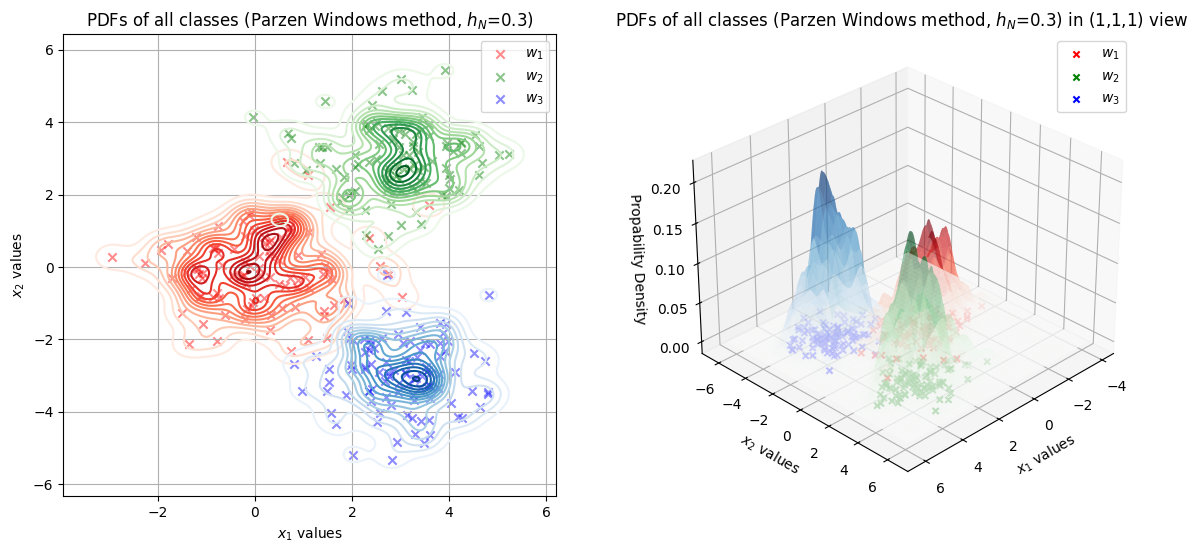

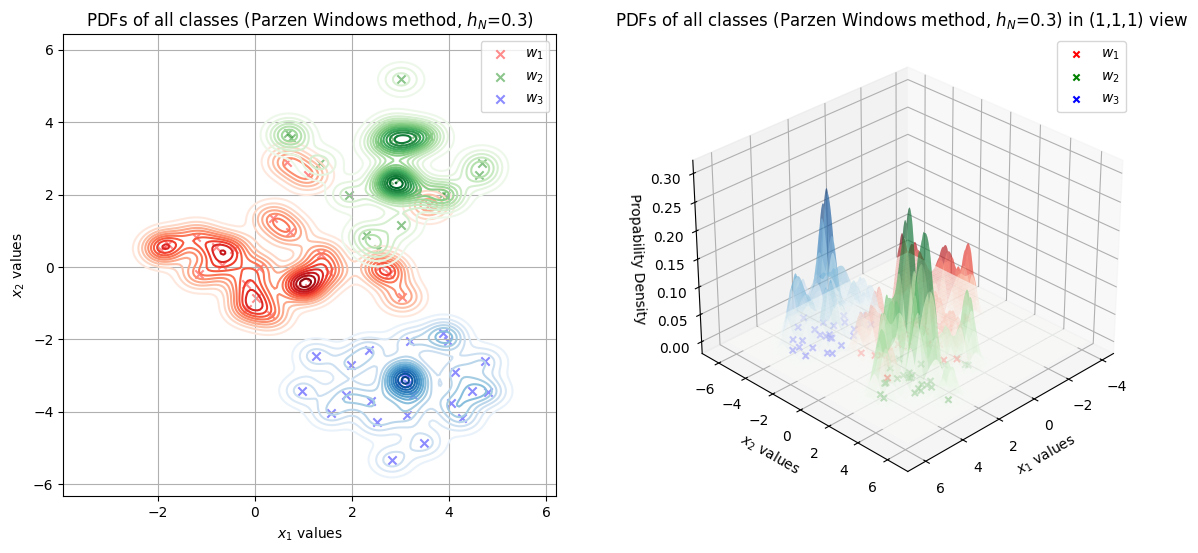

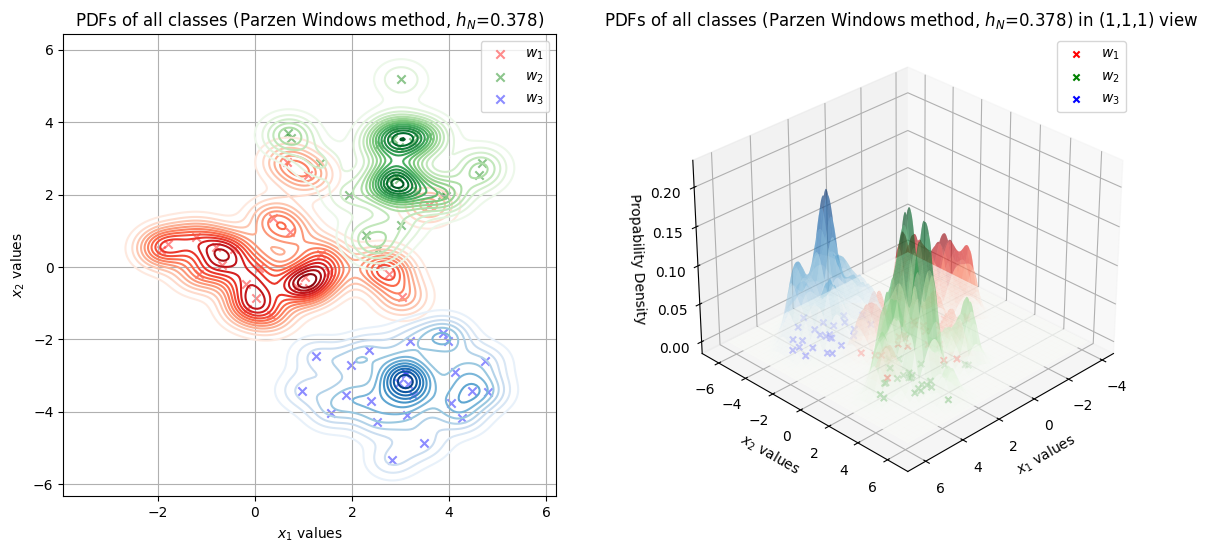

In [ ]:
h_N_old = 0.3
h_N_new = 0.378

# The line below recreates the previous pdf diagrams (h_N = 0.3) for comparison.
pdf_graph_3D(xx1, xx2, classes_w, class_pdfs, h_N_old, 0)

classes_w_reduced = [w1_reduced, w2_reduced, w3_reduced]
p_1_reduced = parzen_pdf(X, w1_reduced[[0,1]].to_numpy(), h_N_old).reshape(xx1.shape)
p_2_reduced = parzen_pdf(X, w2_reduced[[0,1]].to_numpy(), h_N_old).reshape(xx1.shape)
p_3_reduced = parzen_pdf(X, w3_reduced[[0,1]].to_numpy(), h_N_old).reshape(xx1.shape)

pdf_graph_3D(xx1, xx2, classes_w_reduced, [p_1_reduced, p_2_reduced, p_3_reduced], h_N_old, 0)

p_1_reduced_new = parzen_pdf(X, w1_reduced[[0,1]].to_numpy(), h_N_new).reshape(xx1.shape)
p_2_reduced_new = parzen_pdf(X, w2_reduced[[0,1]].to_numpy(), h_N_new).reshape(xx1.shape)
p_3_reduced_new = parzen_pdf(X, w3_reduced[[0,1]].to_numpy(), h_N_new).reshape(xx1.shape)

pdf_graph_3D(xx1, xx2, classes_w_reduced, [p_1_reduced_new, p_2_reduced_new, p_3_reduced_new],
             h_N_new, 0)



### **Β.**

Για τον υπολογισμό των pdf $p(x|ω_1)$, $p(x|ω_2)$ και $p(x|ω_3)$ με την μέθοδο k-NN υπάρχουν δύο πιθανές προσεγγίσεις:

$1)$ Βρίσκουμε τους $k$ πλησιέστερους κατά L2 απόσταση γείτονες του σημείου $x$ ανεξάρτητα από την τάξη στην οποία ανήκουν. Θέτουμε ως $r$ την απόσταση του $x$ από τον k-οστό γείτονα, η οποία ορίζει την (κυκλική για ευκλείδεια απόσταση L2) περιοχή γειτόνων με επιφάνεια (αντί για όγκο, επειδή έχουμε 2 χαρακτηριστικά) $Α=π⋅r^2$.

Ισχύει: $p(x,ω_i)=\frac{k_i/n}{A}$ με $k_i$ τον αριθμό των γειτόνων από τους $k$ που ανήκουν στην κλάση $i$ και $n$ τον συνολικό αριθμό των δειγμάτων όλων των κλάσεων.

Επίσης ισχύει $P(ω_i)=N_i/n$

Επομένως: $p(x|ω_i)=\frac{p(x,ω_i)}{P(ω_i)}=\frac{k_i}{n⋅A⋅\frac{N_i}{n}}=\frac{k_i}{N_i⋅A}=\frac{k_i}{N_i⋅π⋅r^2}$


$2)$ Βρίσκουμε τους $k$ πλησιέστερους κατά L2 απόσταση γείτονες του σημείου $x$ που ανήκουν **μόνο** στην κλάση $i$. Θέτουμε ως $r_i$ την απόσταση του $x$ από τον k-οστό γείτονα, η οποία ορίζει την (κυκλική) περιοχή γειτόνων κλάσης $i$ με επιφάνεια $Α_i=π⋅r_i^2$.

Ισχύει: $p(x,ω_i)=\frac{k/n}{A_i}$ με $n$ τον συνολικό αριθμό των δειγμάτων όλων των κλάσεων.

Επομένως: $p(x|ω_i)=\frac{p(x,ω_i)}{P(ω_i)}=\frac{k}{n⋅A_i⋅\frac{N_i}{n}}=\frac{k}{N_i⋅A}=\frac{k}{N_i⋅π⋅r_i^2}$

Από τις δύο παραπάνω μεθοδολογίες επιλέγεται η *2)* επειδή χρειάζεται μόνο τα δείγματα της κλάσης $i$ για να υπολογίσει το $p(x|ω_i)$, ενώ με την *1)* απαιτείται όλο το Dataset.

Ορισμός της συνάρτησης εύρεσης των $k$ πλησιέστερων γειτόνων. Η συνάρτηση επιστρέφει τις αποστάσεις των πλησιέστερων γειτόνων και τους αντίστοιχους δείκτες τους στα δεδομένα.

**ΠΡΟΣΟΧΗ: ΟΙ ΕΠΙΣΤΡΕΦΟΜΕΝΕΣ ΑΠΟΣΤΑΣΕΙΣ ΔΕΝ ΕΙΝΑΙ ΤΑΞΙΝΟΜΗΜΕΝΕΣ**

In [ ]:
def my_knn(X, X_train, k):

    diffs = X[:, np.newaxis, :] - X_train[np.newaxis, :, :]
    dists_L2 = np.sqrt(np.sum(diffs ** 2, axis = 2))

    knn_idx = np.argpartition(dists_L2, k, axis=1)[:, :k]
    knn_distances = np.take_along_axis(dists_L2, knn_idx, axis=1)
    knn_distances[knn_distances == 0] = np.finfo(float).eps   # To avoid distances of 0

    return knn_distances, knn_idx


Ορισμός της μεθόδου k-NN με βάση με την μεθοδολογία *2)* για την υπολογισμό της pdf $p(x|ω_i)$.

In [ ]:
def knn_pdf(X, x_i, k):

  N_i = len(x_i)

  distances, _ = my_knn(X, x_i, k)
  r_i = distances.max(axis=1)

  pdf = k / (N_i * np.pi * r_i**2)

  return pdf


Εφαρμογή της μεθόδου k-NN για καθεμία από της κλάσεις για $k=10$, $k=3$ και $k=30$. Απεικόνιση και των τριών υπολογισμένων pdf μέσω της *pdf_graph_3D* και για τις τρεις τιμές του $k$.

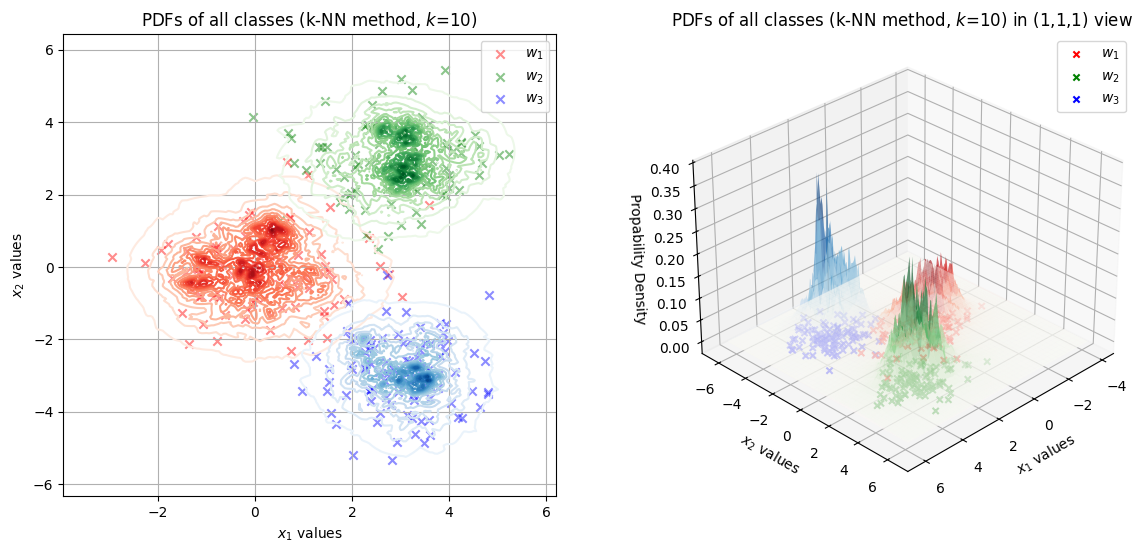

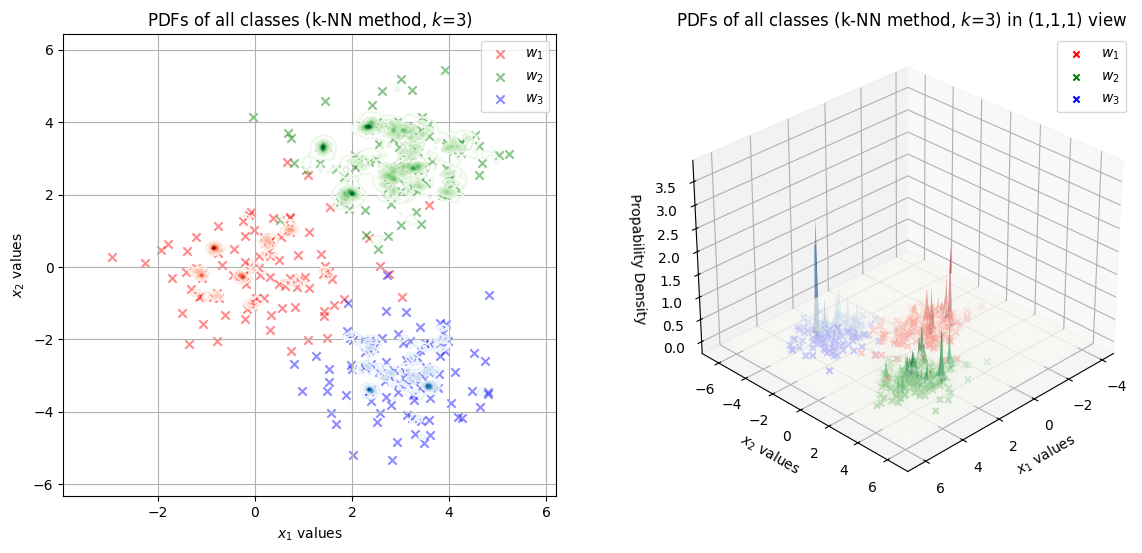

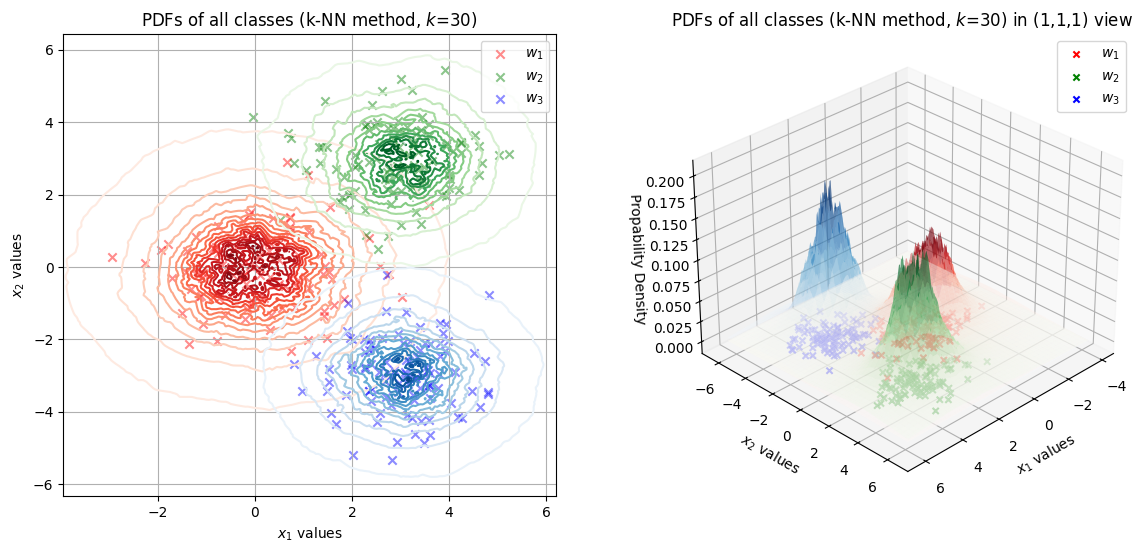

In [ ]:
k = [10, 3, 30]

for kappa in k:

    p_1 = knn_pdf(X, w1[[0,1]].to_numpy(), kappa).reshape(xx1.shape)
    p_2 = knn_pdf(X, w2[[0,1]].to_numpy(), kappa).reshape(xx1.shape)
    p_3 = knn_pdf(X, w3[[0,1]].to_numpy(), kappa).reshape(xx1.shape)

    pdf_graph_3D(xx1, xx2, classes_w, [p_1, p_2, p_3], kappa, 1)


Για κάθε μια από τις τιμές του $k$ παρατηρούμε μέσω των διαγραμμάτων διαφορετικά επίπεδα προσαρμογής στα δεδομένα. Πιο συγκεκριμένα:

*   Για $k=3$ παρατηρείται ότι η τελική pdf της κάθε κλάσης χαρακτηρίζεται από απότομα στενά spikes, κάτι το οποίο αντιστοιχεί σε overfit. Αυτό συμβαίνει διότι στις περιοχές με πολλά δεδομένα, όσο μικρότερο το $k$, τόσο μικρότερη συνήθως η απόσταση $r_i$ από τον k-οστό γείτονα και επομένως μικρότερη επιφάνεια $A_i$ και άρα μεγαλύτερος λόγος $p(x|ω_i)=\frac{k}{N_i⋅π⋅r_i^2}$.

*   Για $k=30$ συμβαίνει το ακριβώς αντίστροφο, δηλαδή η τελική επιφάνεια της pdf δεν διαθέτει αρκετά έντονες ιδιομορφίες, κάτι που αντιστοιχεί σε underfit. Πλεόν το $k$ είναι τόσο μεγάλο, ώστε η απόσταση $r_i$ από τον k-οστό γείτονα να είναι σταθερά μεγάλη και επομένως ο λόγος $p(x|ω_i)=\frac{k}{N_i⋅π⋅r_i^2}$ σταθερός/παρόμοιος στις περισσοτερες περιπτώσεις.

*   Η εφαρμογή της μεθόδου με $k=10$ βρίσκεται ανάμεσα στις δύο περιπτώσεις προσφέροντας ένα εντός οριών smoothing χωρίς να "εξαφανίζει" τα αναγκαία peaks. Δηλαδή το $k$ είναι αρκετά μεγάλο ώστε το $r_i$ να έχει μια λογική διακύμανση στα σημεία του 2D χώρου.

### **Γ.**

Σύμφωνα με την ταξινόμηση κατα Bayes, το $x$ παίρνει την ετικέτα της κλάσης $i$ για την οποία η τιμή του $p(ω_i|x)=\frac{p(x|ω_i)P(ω_i)}{p(x)}$ στο συγκεκριμένο $x$ είναι μεγαλύτερη. Επειδή όμως το $p(x)$ είναι το ίδιο ανεξάρτητα από την κλάση $i$ που εξετάζεται και επειδή  στην συγκεκριμένη περίπτωση και οι τρεις κλάσεις $i$ έχουν την ίδια a priori πιθανότητα $P(ω_i)=1/3, i=1,2,3$, η ταξινόμηση κατά Bayes μπορεί να γίνει με βάση την σχέση:

$ω(x)=\underset{ω_i}{argmax}(p(x|ω_i))$

στην οποία η $p(x|ω_i)$ έχει υπολογιστεί μέσω της μεθόδου παραθύρων Parzen.

Ορισμός συνάρτησης ταξινόμισης κατά Bayes με βάση την παραπάνω σχέση.

In [ ]:
def bayes_classifier(pdf_list):

    pdf_stack = np.stack(pdf_list, axis=0)
    decisions = np.argmax(pdf_stack, axis=0)
    decisions += 1

    return decisions


Ορισμός συνάρτησης για τον σχεδιασμό γραφικής παράστασης του ταξινομημένου χώρου χαρακτηριστικών, όπως και των ορίων απόφασης.

In [ ]:
def plot_classifications(xx1, xx2, classes_w, decisions, method_param, method=0):

    """
    method == 1 → k-NN  (method_param = k)
    method == 0 (default) → Parzen (method_param = h)
    """

    plt.figure(figsize=(7, 5))

    plt.pcolormesh(xx1, xx2, decisions, shading='auto',
                   cmap=ListedColormap(['red', 'green', 'blue']), alpha=0.35)

    plt.scatter(classes_w[0][0], classes_w[0][1], color='r', marker='x', label='$w_1$', alpha=0.55)
    plt.scatter(classes_w[1][0], classes_w[1][1], color='g', marker='x', label='$w_2$', alpha=0.55)
    plt.scatter(classes_w[2][0], classes_w[2][1], color='b', marker='x', label='$w_3$', alpha=0.55)

    plt.xlabel("$x_1$ values")
    plt.ylabel("$x_2$ values")
    if method:
        plt.title(f"Classified feature space (k-NN method, $k$={method_param})")
    else:
        plt.title(f"Classified feature space (Bayes Classification with PDFs from Parzen Windows method, $h_N$={method_param})")
    plt.legend()
    plt.grid(True)
    plt.show()


Ταξινόμηση κατά Bayes μετά από εφαρμογή μεθόδου Parzen Windows για $h_N=0.1$, $h_N=0.3$ και $h_N=1.5$ και οπτικοποίηση.

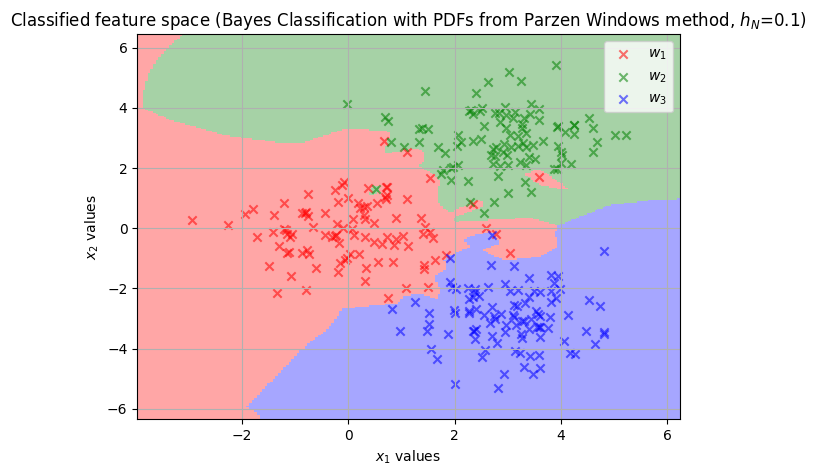

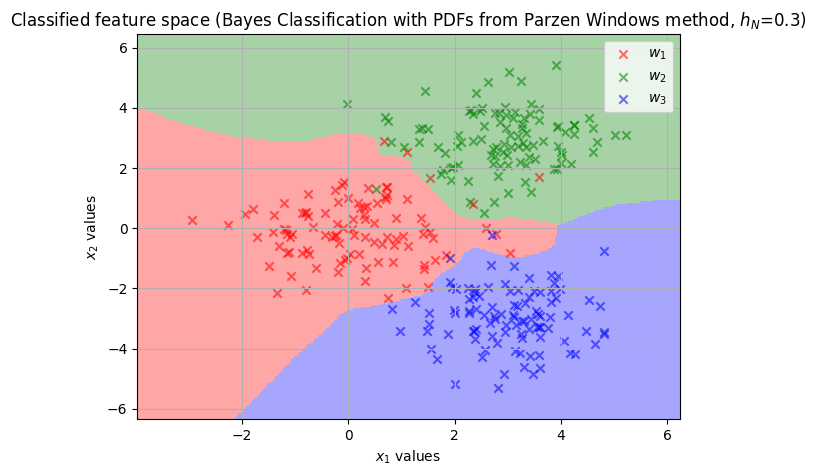

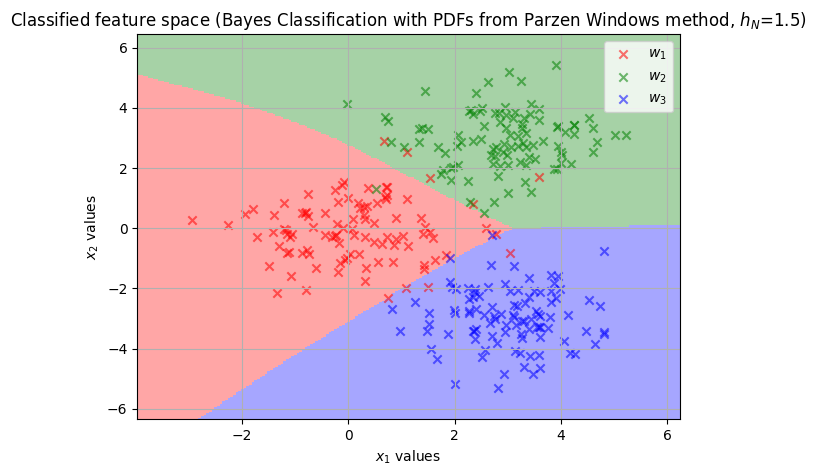

In [ ]:
h_N = [0.1, 0.3, 1.5]

for h in h_N:

    p_1 = parzen_pdf(X, w1[[0,1]].to_numpy(), h).reshape(xx1.shape)
    p_2 = parzen_pdf(X, w2[[0,1]].to_numpy(), h).reshape(xx1.shape)
    p_3 = parzen_pdf(X, w3[[0,1]].to_numpy(), h).reshape(xx1.shape)

    decisions = bayes_classifier([p_1, p_2, p_3])
    plot_classifications(xx1, xx2, [w1, w2, w3], decisions, h, 0)


Όπως φαίνεται από τις τρεις παραπάνω γραφικές παραστάσεις, όσο αυξάνεται η παράμετρος παραθύρου, η προσαρμογή στα δεδομένα μειώνεται. Δηλαδή, για πολύ μικρό παράθυρο ($h_N=0.1$) έχουμε overfitting ενώ για πολύ μεγαλο ($h_N=1.5$) έχουμε underfitting. Αυτό γίνεται ξεκάθαρο από τα όρια απόφασης της κάθε περίπτωσης.

Στην περίπτωση του $h_N=0.1$, η οριοθέτηση είναι πολύ "αυστηρή" με αποτέλεσμα κάθε δείγμα του dataset να βρίσκεται μέσα στην περιοχή απόφασης που αντιστοιχεί στην κλάση του, κάτι το οποίο ανεπιθύμητο σε κάποιες περιπτώσεις.

Από την άλλη, στην περίπτωση του $h_N=1.5$, η οριοθέτηση είναι πολύ "χαλαρή", δηλαδή διαχωρίζονται απλώς οι γενικές περιοχές των κλάσεων, χάνοντας έτσι πολλές αναγκαίες λεπτομέριες.

Στην περίπτωση του $h_N=0.3$ επιτυγχάνεται η ιδανική "αυστηρότητα" οριοθέτησης.

### **Δ.**

Σύμφωνα με την ταξινόμηση κατά κανόνα k-NN, το $x$ παίρνει την ετικέτα της κλάσης $i$ στην οποία ανήκουν οι περισσότεροι από τους $k$ κοντινότερους γείτονες του. Η μέθοδος αυτή ορίζεται με την παρακάτω συνάρτηση.

In [ ]:
def knn_classifier(X, data, k):

    X_train = data[:,0:2]
    y_train = data[:,2].astype(int)

    distances, indices = my_knn(X, X_train, k)

    nbr_labels = y_train[indices]
    decisions = np.array([np.bincount(nbr).argmax() for nbr in nbr_labels]) + 1

    return decisions


Ταξινόμηση σύμφωνα με τον κανόνα k-NN για $k=3$, $k=8$ και $k=30$ και οπτικοποίηση.

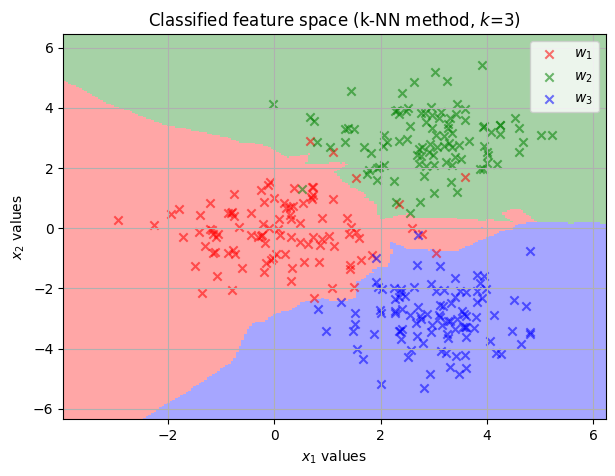

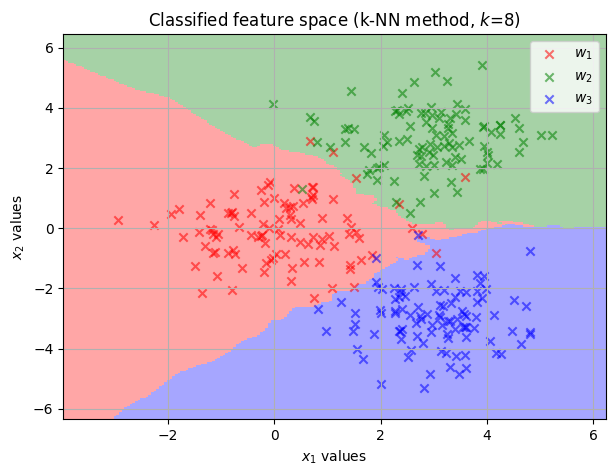

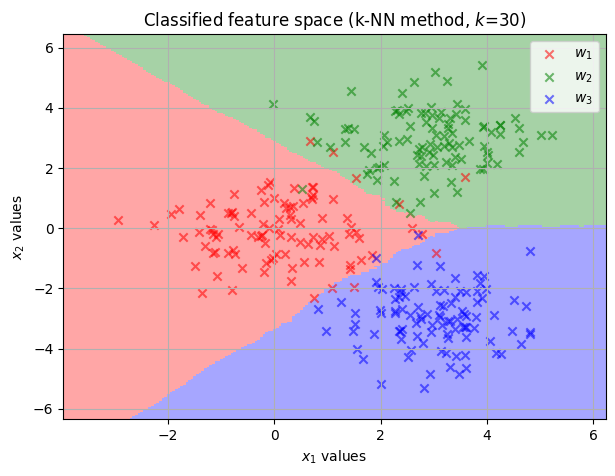

In [ ]:
k = [3, 8, 30]

for kappa in k:

    decisions = knn_classifier(X, df.to_numpy(), kappa).reshape(xx1.shape)
    plot_classifications(xx1, xx2, [w1, w2, w3], decisions, kappa, 1)


Όπως φαίνεται από τις τρεις παραπάνω γραφικές παραστάσεις, η παράμετρος $k$ της k-NN επηρεάζει τις περιοχές απόφασης με τον ίδιο ακριβώς τρόπο που επηρεάζει $h_N$ στο *ερώτημα Γ*. Όσο αυξάνεται ο αριθμός των κοντινότερων γειτόνων που εξετάζονται, η προσαρμογή στα δεδομένα μειώνεται. Αντίστοιχα και εδω, για το πιο μικρό k έχουμε overfitting, για το πιο μεγαλο έχουμε underfitting και για το μεσαίο έχουμε ένα καλό επιπεδο προσαρμογής. Οι παρατηρήσεις ως προς τα όρια απόφασης για την συγκεκριμένη περίπτωση είναι παρόμοιες με του *ερωτήματος Γ*.

### **Ε.**

Η μέθοδος παραθύρων Parzen και η k-NN είναι μη παραμετρικές μέθοδοι οι οποίες εκτιμούν τις κατανομές πιθανότητας μόνο από τα δεδομένα εκπαίδευσης, χωρίς να είναι απαραίτητη η γνώση της κατανομής τους. Συγκριτικά μεταξυ τους:

Τα όρια απόφασης που παράγουν τα παράθυρα Parzen είναι πιο smooth από εκείνα της kNN, αφού οι κατανομές πιθανότητας προκύπτουν από υπέρθεση παραθύρων (και στην συγκεκριμένη περίπτωση Γκαουσσιανών). Η εκτίμηση που κάνουν είναι πιο "soft" από της k-NN και δεν επηρεάζεται από την πυκνότητα των δεδομένων στον χώρο, καθώς η παράμετρος $h_N$, δηλαδή το πλάτος του παραθύρου/της κανονικής, είναι σταθερή στον χώρο. Παρόλα αυτά, είναι πολύ ευαίσθητη στον θόρυβο και δεν αποδίδει καλά όταν αυξάνονται οι διαστάσεις του προβλήματος (και άρα τα δεδομένα απλώνονται περισσότερο στον δειγματοχώρο). Επιπλέον είναι πολύ ευαίσθητη στην ρύθμιση του $h_N$, οδηγώντας σε πολύ διαφορετικά αποτελέσματα όταν αυτό μεταβάλλεται και γενικά η ρύθμιση της θέλει ιδιαίτερη προσοχή γιατί αν είναι αρκετά μικρή προκαλεί overfitting.

Από την άλλη η k-NN, είναι λιγότερο ευαίσθητη στους outliers και τον θόρυβο, αφού η απόφαση βγαίνει από ψηφοφορία. Λειτουργεί καλύτερα από τα παράθυρα Parzen στις υψηλότερες διαστάσεις και η παράμετρός της $k$ είναι γενικά πιο σταθερή από την $h_N$, με την έννοια ότι η μικρή μεταβολή της, κατά πάσα πιθανότητα δεν οδηγεί σε πολύ διαφορετικά αποτελέσματα. Ώστωσο, οπως προαναφέρθηκε, τα όρια απόφασης και οι pdf που παράγει είναι λιγότερο smooth εμφανίζοντας μια "blocky" συμπεριφορά στα όρια απόφασης. Επιπλέον, οι αποφάσεις τις εξαρτώνται πολύ από την πυκνότητα των κλάσεων στον χώρο και παρουσιάζει bias προς της τάξεις με περισσσότερα στοιχεία.

Tώρα, συγκριτικά με τις γεωμετρικές τεχνικές ταξινόμησης, εμφανίζουν επίσης σημαντικά προτερήματα και ελαττώματα. Τα θετικά είναι ότι είναι ευέλικτες στον τύπο της καμπύλης απόφασης που εκτιμούν, σε αντίθεση με άλλους ταξινομητές, όπως τους γραμμικούς που προσαρμόζουν μόνο ευθεία. Επιπλέον είναι απλές μέθοδοι με πολύ εύκολη υλοποίηση, έναντι με τις γεωμετρικές που είναι κατά βάση προβλήματα optimization παρμέτρων.

Οι αδυναμίες όμως που παρουσιάζουν είναι το curse of dimensionality, δηλαδή όσο αυξάνονται οι διαστάσεις του προβλήματος, η απαίτηση για δεδομένα εκπαίδευσης γίνεται τεράστια, κάτι το οποίο δεν συμβαίνει με αλγοριθμους όπως τον SVM, κτλ. Επιπλέον, αν και η υλοποίηση τους είναι εύκολη, είναι υπολογιστικά πολύ κοστοβόρες μέθοδοι, καθώς εκτελούν τους υπολογισμούς τους σε όλο το σύνολο των δεδομένων με αποτέλεσμα να έχουν πολύ χειρότερο scalability.

---

## **Άσκηση 2**

Παραγωγή 150 δειγμάτων κλάσης $ω_1$ και 150 κλάσης $ω_2$.

Η κλάση $ω_1$ ακολουθεί την pdf $p(x|ω_1)=Ν(μ_1,Σ_1)$ με $μ_1=\begin{bmatrix}2 \\ 2\end{bmatrix}$ και $Σ_1=\begin{bmatrix}2 & -0.5 \\ -0.5 & 1 \end{bmatrix}$.


Η κλάση $ω_2$ ακολουθεί την pdf $p(x|ω_2)=Ν(μ_2,Σ_2)$ με $μ_2=\begin{bmatrix}-8 \\ 2\end{bmatrix}$ και $Σ_2=\begin{bmatrix}1 & 0.5 \\ 0.5 & 1 \end{bmatrix}$.

In [ ]:
N = 150     # Num of samples

u1 = np.array([2, 2])
cov1 = np.array([[2, -0.5],[-0.5, 1]])

u2 = np.array([-8, 2])
cov2 = np.array([[1, 0.5],[0.5, 1]])

w1 = np.random.multivariate_normal(u1, cov1, N)
w2 = np.random.multivariate_normal(u2, cov2, N)

Παράσταση σε κοινό διάγραμμα των δειγμάτων της κάθε κλάσης, καθώς και των κατανομών από τις οποίες προήλθαν, στον χώρο των χαρακτηριστικών.

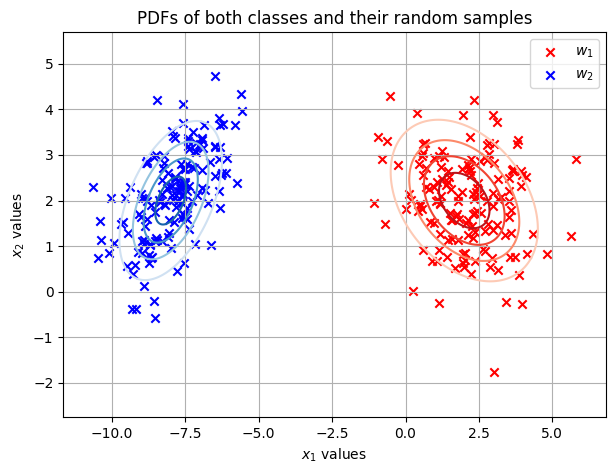

In [ ]:
samples = np.concatenate((w1,w2), axis=0)

x1 = np.arange(samples[:,0].min()-1, samples[:,0].max()+1, 0.01)
x2 = np.arange(samples[:,1].min()-1, samples[:,1].max()+1, 0.05)

xx1, xx2 = np.meshgrid(x1,x2)
pos = np.dstack((xx1,xx2))

w1_distribution = stats.multivariate_normal(u1, cov1)
w2_distribution = stats.multivariate_normal(u2, cov2)

z1 = w1_distribution.pdf(pos)
z2 = w2_distribution.pdf(pos)

plt.figure(figsize=(7, 5))

plt.contour(xx1, xx2, z1, levels=5, cmap = 'Reds')
plt.scatter(w1[:,0], w1[:,1], color='r', marker='x', label="$w_1$")

plt.contour(xx1, xx2, z2, levels=5, cmap = 'Blues')
plt.scatter(w2[:,0], w2[:,1], color='b', marker='x', label="$w_2$")

plt.title(f"PDFs of both classes and their random samples")
plt.xlabel("$x_1$ values")
plt.ylabel("$x_2$ values")
plt.legend()
plt.grid(True)
plt.show()

### **Α.**

Ο αλγόριθμος Batch Perceptron προσπαθεί να βρεί τις παραμέτρους $a$ του υπερεπιπέδου που ελαχιστούν τη συνάρτηση κριτηρίου Perceptron:

$J_p(a)=∑_{yϵY}{(-a^ty)}$ με $Y(a)$ το σύνολο των δειγμάτων που δεν έχουν ταξινομηθεί σωστά από το $a$.

Το διάνυσμα κλίσεων είναι το $∇J_p(a)=\frac{ϑJ_p}{ϑa_i}=∑_{yϵY}{-y}$ άρα η αναδρομική σχέση είναι $a(k+1)=a(k)+h(k)∑_{yϵY}y$

Ορισμός της συνάρτησης που εκτελεί τον αλγόριθμο Batch Perceptron με δυνατότητα ορισμού learning rate *lr*, του ελάχιστου update των βαρών για να μην τερματίσει η εκτέλεση *theta* και του μέγιστου αριθμού επαναλήψεων *max_iter*.

In [ ]:
def batch_perceptron(Y, lr=1.0, theta=1e-5, max_iter=1000):

    # a = np.zeros(Y.shape[1])
    a = 10* np.random.rand(Y.shape[1]) - 5   # Random initial weights to avoid stop at 0 iterations

    for k in range(max_iter):

        gradient_J = np.sum(Y[Y @ a <= 0], axis=0)

        delta = lr * gradient_J
        a = a + delta

        if np.linalg.norm(delta) < theta:
            print(f"Early stopped at in iter={k} because update < threshold = {theta}")
            return a

    print(f"Stopped because max iterations ({max_iter}) were reached.")
    return a



**Σχόλιο:** Οπως θα φανεί και παρακάτω, τα δεδομένα είναι τέτοια ώστε αν αρχικοποιήσουμε το διάνυσμα $a$ του υπερεπιπέδου με μηδενικά, το υπερεπίπεδο τα καταφέρνει ήδη μόνο με την αρχικοποίηση να διαχωρίζει τα δεδομένα. Αυτό σε αλγορίθμους όπως το batch perceptron, δεν προκαλεί μεγάλο θέμα, τουλάχιστον σε αυτά τα δεδομένα, αλλά σε άλλους όπως την μέθοδο Ho-Kashyap προκαλεί τον απευθείας τερματισμό της εκτέλεσης σε αυτό το τοπικό ελάχιστο.

Επομένως, σε όλες τις συναρτήσεις ταξινόμησης έχει προστεθεί η εντολή τυχαίας αρχικοποίησης του $a$, η οποία χρησιμοποιείται όπου είναι αναγκαία. Όπου δεν είναι απαραίτητη, είναι μέσα σε σχόλια, έτσι ώστε σε διαδοχικές εκτελέσεις να μην έχουν διαφορετικά αποτελέσματα.

Προετοιμασία των δεδομένων για τον αλγόριθμο Batch Perceptron, εφαρμογή του αλγορίθμου και αναπαράσταση των δειγμάτων και του υπολογισμένου decision boundary στο ίδιο διάγραμμα.

Η προετοιμασία των δεδομένων αφορά κυρίως την προσθήκη των απαραίτητων για τους αλγορίθμους ετικετών στα δείγματα.

Early stopped at in iter=109 because update < threshold = 1e-05

Batch Perceptron hyperplane parameters:
[1144.37852849  508.4928306   232.94798536]



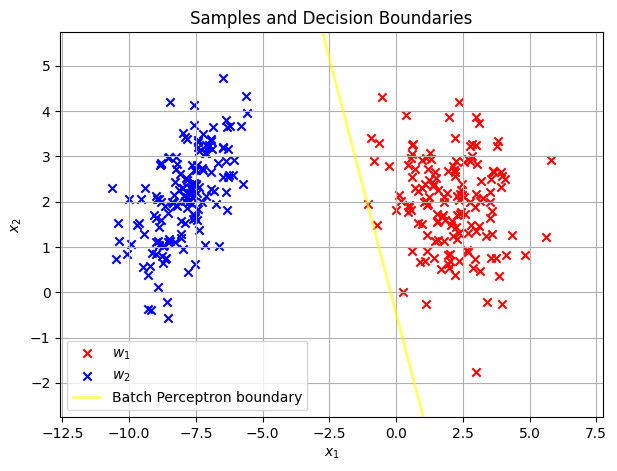

In [ ]:
Y1 = np.hstack((w1, np.ones((N, 1))))
Y2 = np.hstack((w2, np.ones((N, 1))))

t1 = np.ones(N)      # Class w1: label +1
t2 = -np.ones(N)     # Class w2: label -1

Y1 = t1[:, None] * Y1
Y2 = t2[:, None] * Y2

Y = np.vstack((Y1, Y2))

a_p = batch_perceptron(Y, lr=0.9)

w1_p, w2_p, b_p = a_p
g_p = -(w1_p * x1 + b_p) / w2_p

print("\nBatch Perceptron hyperplane parameters:")
print(f"{a_p}\n")


plt.figure(figsize=(7, 5))

plt.scatter(w1[:,0], w1[:,1], color='r', marker='x', label="$w_1$")
plt.scatter(w2[:,0], w2[:,1], color='b', marker='x', label="$w_2$")

plt.plot(x1, g_p, color='yellow', linewidth=2, alpha=0.6, label="Batch Perceptron boundary")

plt.title(f"Samples and Decision Boundaries")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.ylim(samples[:,1].min()-1, samples[:,1].max()+1)
plt.legend()
plt.grid(True)
plt.show()

### **Β.**

Ορισμός της συνάρτησης που εκτελεί την μέθοδο Ho-Kashyap με δυνατότητα ορισμού learning rate *lr*, του ελάχιστου update των βαρών για να μην τερματίσει η εκτέλεση *theta* και του μέγιστου αριθμού επαναλήψεων *max_iter*.

Ο αλγόριθμος Ho-Kashyap προσπαθεί να βρεί τις παραμέτρους $a$ του υπερεπιπέδου και το θετικό όριο $b$ που ελαχιστούν τη συνάρτηση:

$J_s(a,b)=||Ya-b||^2$ με $b>0$


Υπάρχουν δύο εκδοχές του ίδιο αλγορίθμου οι οποίες είναι ισοδύναμες.

Το παρακάτω codeblock ορίζει την πρώτη εκδοχή, η οποία πραγματοποιεί τις ανανεώσεις των παραμέτρων αξιοποιώντας ένα από τα δείγματα κάθε φορά (online).

In [ ]:
def ho_kashyap_online(Y, lr=1, theta=1e-5, max_iter=100000):

    n_samples, dims = Y.shape
    b = np.ones(n_samples)
    # a = np.zeros(dims)
    a = 10 * np.random.rand(dims) - 5    # Random initial weights to avoid stop at 0 iterations

    YtY_inv_Yt = np.linalg.inv(Y.T @ Y) @ Y.T


    k=0
    for iteration in range(max_iter):

        yk = Y[k]
        bk = b[k]

        ek = yk @ a - bk
        ek_pos = (ek + np.abs(ek)) / 2
        b[k] = bk + 2 * lr * ek_pos
        a = YtY_inv_Yt @ b

        e = Y @ a - b
        e_pos = (e + np.abs(e)) / 2

        if np.linalg.norm(e_pos) < theta:
            print(f"Early stopped at in iter={k}, sample={k} because update < threshold = {theta}")
            return a

        k = (k + 1) % n_samples

    print(f"Stopped because max iterations ({max_iter}) were reached. - no solution found")
    return a



Το παρακάτω codeblock ορίζει την δεύτερη εκδοχή, η οποία πραγματοποιεί τις ανανεώσεις των παραμέτρων αξιοποιώντας όλα τα δείγματα (batch).

In [ ]:
def ho_kashyap_batch(Y, lr=1, theta=1e-5, max_iter=10000):

    n_samples, dims = Y.shape
    b = np.ones(n_samples)
    # a = np.zeros(dims)
    a = 10 * np.random.rand(dims) - 5    # Random initial weights to avoid stop at 0 iterations

    YtY_inv_Yt = np.linalg.inv(Y.T @ Y) @ Y.T

    for iteration in range(max_iter):

        e = Y @ a - b
        e_pos = (e + np.abs(e)) / 2
        b = b + 2 * lr * e_pos
        a = YtY_inv_Yt @ b

        if np.linalg.norm(e_pos) < theta:
            print(f"Early stopped at in iter={iteration}, because update < threshold = {theta}")
            return a

    print(f"Stopped because max iterations ({max_iter}) were reached. - no solution found")
    return a



Από τις δύο παραπάνω εκδοχές επιλέγεται να χρησιμοποιηθεί η δεύτερη γιατί ως αναμενόμενο απαιτεί λιγότερα iterations για να συγκλίνει.

Εφαρμογή της μεθόδου (Batch) Ηo-Κashyap και σχεδίαση του υπολογισμένου decision boundary στο προηγούμενο διάγραμμα.

Early stopped at in iter=3450, because update < threshold = 1e-05

Ho-Kashyap hyperplane parameters:
[12.37429439 -3.51483778 24.59283779]



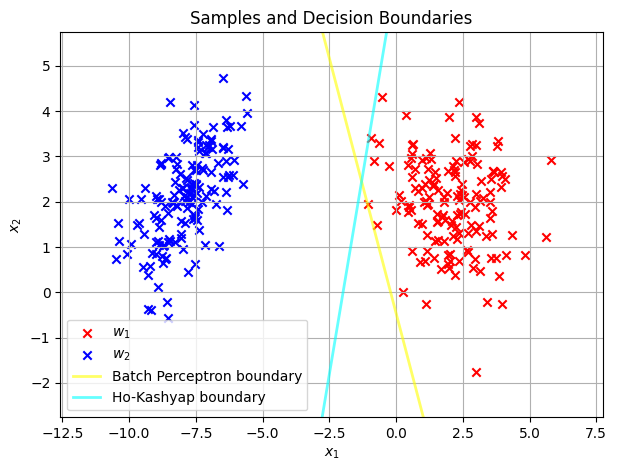

In [ ]:
a_H_K = ho_kashyap_batch(Y, lr=0.9)

w1_H_K, w2_H_K, b_H_K = a_H_K
g_H_K = -(w1_H_K * x1 + b_H_K) / w2_H_K

print("\nHo-Kashyap hyperplane parameters:")
print(f"{a_H_K}\n")


plt.figure(figsize=(7, 5))

plt.scatter(w1[:,0], w1[:,1], color='r', marker='x', label="$w_1$")
plt.scatter(w2[:,0], w2[:,1], color='b', marker='x', label="$w_2$")

plt.plot(x1, g_p, color='yellow', linewidth=2, alpha=0.6, label="Batch Perceptron boundary")
plt.plot(x1, g_H_K, color='cyan', linewidth=2, alpha=0.6, label="Ho-Kashyap boundary")

plt.title(f"Samples and Decision Boundaries")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.ylim(samples[:,1].min()-1, samples[:,1].max()+1)
plt.legend()
plt.grid(True)
plt.show()

### **Γ.**

Ο SVM προσπαθεί να βρεί το υπερεπίπεδο $g(x)=w^Tφ(x)+w_0=∑_{i}{a_iy_iK(x_i,x)}+b$, οι παράμετροι w του οποίου ελαχιστοποιούν την συνάρτηση $J(w,w_0)=\frac{1}{2}||w||^2$ (hard margin) για γραμμικά διαχωρίσιμες κλάσεις όπως εδώ. Η $φ(.)$ είναι μια απεικόνιση σε μεγαλύτερη διάσταση στην οποία το πρόβλημα ειναι γραμμικό και $K(x,x_i)$ η αντίστοιχη συνάρτηση kernel.

Δεδομένου ότι το πρόβλημα είναι ήδη γραμμικώς επιλύσιμο, για τον SVM χρησιμοποιείται γραμμικός kernel ο οποίος δίνεται από την σχέση $K(x,x_i)=x_i^Tx$ και επομένως γίνεται $g(x)=w^Τx+w_0$.

Εύρεση παραμέτρων υπερεπιπέδου μέσω SVM γραμμικού kernel της βιβλιοθήκη LIBSVM (https://www.csie.ntu.edu.tw/~cjlin/libsvm/) και σχεδίαση του υπολογισμένου decision boundary στο προηγούμενο διάγραμμα.


SVM hyperplane parameters:
[ 0.42584365 -0.04381869  1.54966302]



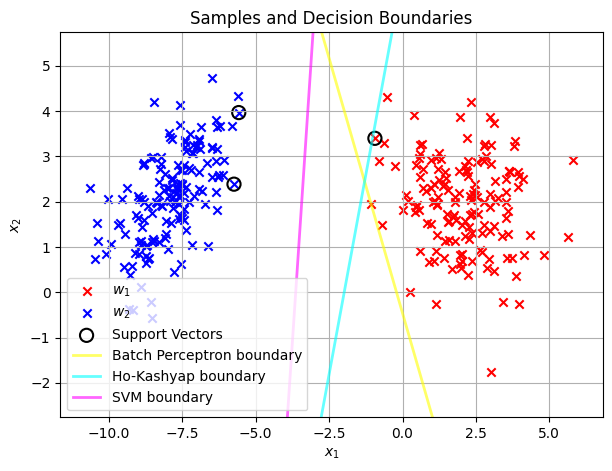

In [ ]:
y_SVM = Y[:,2]
y_SVM = y_SVM.tolist()

model = svm_train(y_SVM, samples, "-t 0 -c 1")

SVs_coef = model.get_sv_coef()  # List of typles (contains: SVs a_i*y_i values)
SVs = model.get_SV()   # List of SVM dictionaries

SVs_array = np.array([[sv.get(1,0), sv.get(2,0)] for sv in SVs])  # Convert to array
SVs_coef_array = np.array([alpha[0] for alpha in SVs_coef])  # Convert to array
w_SVM = SVs_coef_array @ SVs_array  # w = Sum_i{ (a_i*y_i) * x_i }
b_SVM = -model.rho[0]

g_SVM = -(w_SVM[0]*x1 + b_SVM) / w_SVM[1]


print("\nSVM hyperplane parameters:")
print(f"{np.array([w_SVM[0], w_SVM[1], b_SVM])}\n")

plt.figure(figsize=(7, 5))

plt.scatter(w1[:,0], w1[:,1], color='r', marker='x', label="$w_1$")
plt.scatter(w2[:,0], w2[:,1], color='b', marker='x', label="$w_2$")
plt.scatter(SVs_array[:,0], SVs_array[:,1], s=90, edgecolors='k', facecolors='none',
            linewidths=1.5, label="Support Vectors")

plt.plot(x1, g_p, color='yellow', linewidth=2, alpha=0.6, label="Batch Perceptron boundary")
plt.plot(x1, g_H_K, color='cyan', linewidth=2, alpha=0.6, label="Ho-Kashyap boundary")
plt.plot(x1, g_SVM, color='magenta', linewidth=2, alpha=0.6, label="SVM boundary")

plt.title(f"Samples and Decision Boundaries")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(samples[:,0].min()-1, samples[:,0].max()+1)
plt.ylim(samples[:,1].min()-1, samples[:,1].max()+1)
plt.legend()
plt.grid(True)
plt.show()

**Σχόλιο:** Όπως φαίνεται παραπάνω, κατά την δημιουργία του ταξινομητή SVM υπάρχει μία παράμετρος $C$ η οποία ρυθμίζεται ίση με 1 (default). Αυτή η παράμετρος ονομάζεται Box Constraint και και καθορίζει το βάρος που δίνουμε στην ύπαρξη λαθών. Δηλαδή, δεν υπάρχει κάποια ρύθμιση της SVM της LIBSVM που να ορίζει απευθείας ότι το πρόβλημα είναι γραμμικά διαχωρίσιμο και άρα να μην επιτρέπει την ύπαρξη λαθών. Επομένως όλες οι SVM προσπαθούν να ελαχιστοποιήσουν την συνάρτηση soft margin $J(w,w0)=\frac{1}{2}||w||^2+C∑_{i=1}^{N}ξ_i$, όπου $ξ_i$ είναι ένα επιτρεπόμενο λάθος. Αν θέλουμε να ελαχιστοποιήσουμε μια hard margin συνάρτηση τότε κανονικά θα έπρεπε να θέσουμε το $C$ πάρα πολύ ψηλό, π.χ. $C=1e6$, αλλά δεν χρειάζεται σε αυτήν την περίπτωση γιατί το πρόβλημα είναι γραμμικώς διαχωρίσιμο και άρα θα έχουν χαμηλότερη τιμή συνάρτησης κόστους οι λύσεις χωρίς λάθη $ξ$. Για αυτό και $C=1$, επειδή θα λειτουργούσε ο αλγόριθμος το ίδιο καλά με οποιαδήποτε τιμή $C$.

### **Δ.**

Mετά από πολλαπλές εκτελέσεις των παραπάνω αλγορίθμων, γίνεται ξεκάθαρο ότι τα υπερεπίπεδα/όρια απόφασης των τριών τεχνικών παρουσιάζουν σημαντικές διαφορές μεταξύ τους:


*   SVM: Το υπερεπίπεδο του SVM είναι το καλύτερο από τα τρία. Είναι σταθερό μεταξύ διαδοχικών εκτελέσεων και έχει την μέγιστη δυνατή απόσταση $m$ (margin) από τις δυο κλάσεις δίνοντας μέγιστη διακριτικότητα μεταξύ των δύο κλάσεων. Αυτό οφείλετε στην συνάρτηση κριτηρίου perceptron, που αποσκοπεί σε ακριβώς αυτό.
*   Ho-Kashyap: Το υπερεπίπεδο του Ho-Kashyap είναι το αμέσως καλύτερο μετά του SVM και αυτό οφείλεται στην ύπαρξη του ορίου $b$. Αν και η συγκεκριμένη τεχνική δεν οδηγεί σε υπερεπίπεδο μέγιστης απόστασης από τις δύο κλάσεις, η παράμετρος $b$ προσδίδει ένα margin ασφαλείας από κάποια από τα δείγματα των κλάσεων. Αυτό σημαίνει ότι το όριο απόφασης δεν έρχεται (πάντα) σε επαφή με τα συνοριακά δείγματα κλάσεων. Το μόνο πρόβλημα είναι ότι αυτή η τεχνική εξαρτάται πάρα πολύ από το αρχικό υπερεπίπεδο και ανάμεσα σε διαδοχκές εκτελέσεις (με randomised αρχικό υπερεπίπεδο) μπορεί να οδηγήσει σε τελείως διαφορετικές λύσεις.
*  Perceptron: Αν και προφανώς επιλύει σωστά το πρόβλημα της γραμμικής ταξινόμησης, το Perceptron προσφέρει το χειρότερο υπερεπίπεδο από τα τρία λόγω της απουσία εννοιών όπως το $m$ και το $b$. Αν και οι λύσεις μεταξύ διαδοχικων εκτελέσεων (με randomised αρχικό υπερπίπεδο) είναι σχετικά σταθερές, το τελικό επίπεδο (σχεδόν) πάντα βρίσκεται σε επαφή με τα συνοριακά δείγματα κλάσης πράγμα το οποίο δεν είναι βέλτιστο.



---

## **Άσκηση 3**

Φόρτωση των δεδομένων του Wine dataset (*wine.data* αρχείο). Ονομασία της κάθε στήλης (καθαρά προαιρετικό για καλύτερη κατανόηση) και εκτύπωση χρήσιμων πληροφοριών για τα δεδομενα

In [ ]:
columns = ['Cultivar', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
           'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
           'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
           'Proline']

class_column = columns[0]
data_columns = columns[1:]


df = pd.read_csv("wine.data", header=None, names=columns)


print(df.info())

print('\n-------------------- Class Info --------------------\n')

print(df[class_column].value_counts())
print()
print(df[class_column].value_counts(normalize=True))

print ('\n----------------------------------------------------\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Cultivar                      178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity of ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280/OD315 of diluted wines  178 non-null    float64
 13  Proli

### **Α.**

Επιλογή υποσυνόλου του dataset (τα 5 πρώτα features από τις κλασεις c2 και c3) και spliting σε Training, Validation και  Testing μέσω της *train_test_split* της *sklearn*. Ο διαχωρισμός είναι stratified (διατήρηση αναλογιών κλάσεων) και τα 3 μέρη είναι σε αναλογία 50%, 25% και 25% αντίστοιχα.

In [ ]:
chosen_columns = columns[:6]

df_0to5 = df[chosen_columns]
df_c23 = df_0to5[df_0to5['Cultivar'].isin([2, 3])]

X = df_c23[chosen_columns[1:]]
y = df_c23[class_column]

# 100% Dataset ---> 75% Temp (=Training + Validation) + 25% Testing
X_temp, X_test, y_temp, y_test = train_test_split(X, y,
                                                  test_size=0.25,
                                                  stratify=y,
                                                  random_state=state)

# 75% Temp ---> 87.5% Training (70% of Dataset) + 12.5% Validation  (10% of Dataset)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                  test_size=1/3,
                                                  stratify=y_temp,
                                                  random_state=state)

print("Data before split:", X.shape)
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

print("\n====== Class counts [c2, c3] ======")
print("Train:", np.bincount(y_train - 2))
print("Val:  ", np.bincount(y_val - 2))
print("Test: ", np.bincount(y_test - 2))

Data before split: (119, 5)
Training set: (59, 5)
Validation set: (30, 5)
Test set: (30, 5)

====== Class counts [c2, c3] ======
Train: [35 24]
Val:   [18 12]
Test:  [18 12]


### **Β.**

Εφαρμογή Standard Scaling στα δεδομένα από υπολογισμό μέσου όρου και τυπικής απόκλισης ΜΟΝΟ από τα training δεδομένα. Εκπαίδευση (για μη γραμμικό πρόβλημα) SVM ταξινομητή γραμμικού kernel $K(x,y)=x^Ty$ της βιβλιοθήκη LIBSVM (https://www.csie.ntu.edu.tw/~cjlin/libsvm/). Λεπτομέριες για το πως λειτουργεί ο SVM υπάρχουν στην απάντηση του *ερωτήματος 2.Γ*.

Ο ταξινομητής εκπαιδεύεται για διάφορες τιμές τις παραμέτρου C σε δύο στάδια. Το optimization γίνεται σε πρώτη φάση μέσω grid search και σε δεύτερη φάση πάλι μέσω grid search αλλά γύρω από την optimal C του προηγούμενου σταδίου.

In [ ]:
# Standard Scaling
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train_n = ((X_train - mean) / std).to_numpy()
X_val_n = ((X_val - mean) / std).to_numpy()
X_test_n = ((X_test - mean) / std).to_numpy()


C_values = np.logspace(-3,3,7)
C_values = np.append(C_values, 1e6)  # Huge C for hard margin

best_C = None
best_val_acc = -1
best_model = None

print("Tuning C on validation set...\n")
print("\n========== Grid Search ==========\n")
for C in C_values:

    model = svm_train(y_train.tolist(), X_train_n.tolist(), f'-s 0 -t 0 -c {C}')
    _, p_acc, _ = svm_predict(y_val.tolist(), X_val_n.tolist(), model, options='-q')

    val_acc = p_acc[0]

    print(f"C={C} → Validation accuracy: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_C = C
        best_model = model

print(f"\nBest C = {best_C} with Val Acc = {best_val_acc:.2f}%")
print("\n=================================\n")


C_fine = np.logspace(np.log10(best_C / 2), np.log10(best_C * 2), num=10)
C_fine = np.round(C_fine, 10)

print("\n======= Finer Grid Search =======\n")
for C in C_fine:

    model = svm_train(y_train.tolist(), X_train_n.tolist(), f'-s 0 -t 0 -c {C}')
    _, p_acc, _ = svm_predict(y_val.tolist(), X_val_n.tolist(), model, options='-q')

    val_acc = p_acc[0]

    print(f"C={C} → Validation accuracy: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_C = C
        best_model = model

print(f"\nBest  C = {best_C} with Val Acc = {best_val_acc:.2f}%")
print("\n=================================\n")


Tuning C on validation set...


========== Grid Search ==========

C=0.001 → Validation accuracy: 60.00%
C=0.01 → Validation accuracy: 63.33%
C=0.1 → Validation accuracy: 90.00%
C=1.0 → Validation accuracy: 86.67%
C=10.0 → Validation accuracy: 86.67%
C=100.0 → Validation accuracy: 86.67%
C=1000.0 → Validation accuracy: 86.67%
C=1000000.0 → Validation accuracy: 76.67%

Best C = 0.1 with Val Acc = 90.00%



======= Finer Grid Search =======

C=0.05 → Validation accuracy: 90.00%
C=0.058326452 → Validation accuracy: 90.00%
C=0.0680395 → Validation accuracy: 90.00%
C=0.0793700526 → Validation accuracy: 90.00%
C=0.0925874712 → Validation accuracy: 90.00%
C=0.1080059739 → Validation accuracy: 90.00%
C=0.125992105 → Validation accuracy: 86.67%
C=0.1469734492 → Validation accuracy: 86.67%
C=0.1714487966 → Validation accuracy: 86.67%
C=0.2 → Validation accuracy: 86.67%

Best  C = 0.1 with Val Acc = 90.00%




Αξιολόγηση του καλύτερου μοντέλου εκπαίδευσης στα Testing δεδομένα.

In [ ]:
_, test_acc, _ = svm_predict(y_test.tolist(), X_test_n.tolist(), best_model,
                             options='-q')

classification_error = 100 - test_acc[0]

print("====== Linear SVM Best Model Testing ======\n")
print(f"Test Accuracy:             {test_acc[0]:.2f}%")
print(f"Test Classification Error: {classification_error:.2f}%\n")
print("===========================================")

====== Linear SVM Best Model Testing ======

Test Accuracy:             86.67%
Test Classification Error: 13.33%



Στο παραπάνω οutput φαίνεται ότι το επιτυγχάνεται σφάλμα ταξινόμησης 13.33%.

### **Γ.**

Επανάληψη των ίδιων ακριβώς διαδικασιών του *ερωτήματος Β*, αλλά για 5 διαφορετικούς διαχωρισμούς των δεδομένων. Ο διαχωρισμός γίνεται ακριβώς όπως στο *ερώτημα Α* μόνο που σε καθέναν από τους 5 διαχωρισμούς, το seed είναι διαφορετικό.

In [ ]:
n_runs = 5


classification_errors = []
for run in range(n_runs):

    print(f"=============== Run {run+1} of 5 ===============\n")
    iteration_state = state + run + 1

    # 75% Temp (=Training + Validation) + 25% Testing
    X_temp, X_test, y_temp, y_test = train_test_split(X, y,
                                                      test_size=0.25,
                                                      stratify=y,
                                                      random_state=iteration_state)

    # 75% Temp ---> 87.5% Training (70% of Dataset) + 12.5% Validation  (10% of Dataset)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                      test_size=1/3,
                                                      stratify=y_temp,
                                                      random_state=iteration_state)

    # Standard Scaling
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)

    X_train_n = ((X_train - mean) / std).to_numpy()
    X_val_n = ((X_val - mean) / std).to_numpy()
    X_test_n = ((X_test - mean) / std).to_numpy()


    C_values = np.logspace(-3,3,7)
    C_values = np.append(C_values, 1e6)  # Huge C for hard margin

    best_C = None
    best_val_acc = -1
    best_model = None

    print("Tuning C on validation set...\n")
    print("---------- Grid Search ----------\n")
    for C in C_values:

        model = svm_train(y_train.tolist(), X_train_n.tolist(), f'-s 0 -t 0 -c {C}')
        _, p_acc, _ = svm_predict(y_val.tolist(), X_val_n.tolist(), model, options='-q')

        val_acc = p_acc[0]

        print(f"C={C} → Validation accuracy: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_C = C
            best_model = model

    print(f"\nBest C = {best_C} with Val Acc = {best_val_acc:.2f}%")
    print("\n---------------------------------\n")


    C_fine = np.logspace(np.log10(best_C / 2), np.log10(best_C * 2), num=10)
    C_fine = np.round(C_fine, 10)

    print("\n------- Finer Grid Search -------\n")
    for C in C_fine:

        model = svm_train(y_train.tolist(), X_train_n.tolist(), f'-s 0 -t 0 -c {C}')
        _, p_acc, _ = svm_predict(y_val.tolist(), X_val_n.tolist(), model, options='-q')

        val_acc = p_acc[0]

        print(f"C={C} → Validation accuracy: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_C = C
            best_model = model

    print(f"\nBest  C = {best_C} with Val Acc = {best_val_acc:.2f}%")
    print("\n---------------------------------\n")


    _, test_acc, _ = svm_predict(y_test.tolist(), X_test_n.tolist(), best_model,
                             options='-q')

    classification_error = 100 - test_acc[0]
    classification_errors.append(classification_error)

    print(f"\n--- Testing of Best Model of Run {run+1} ---\n")
    print(f"Test Accuracy:             {test_acc[0]:.2f}%")
    print(f"Test Classification Error: {classification_error:.2f}%\n")
    print("--------------------------------------\n")
    print("==========================================\n\n")


mean_error = np.mean(classification_errors)
std_error = np.std(classification_errors)


print("============= FINAL RESULTS ==============\n")
for run in range(n_runs):
    print(f"Run {run+1} Test Error: {classification_errors[run]:.2f}%")
print(f"\nRun Mean Test Classification Error: {mean_error:.2f}%")
print(f"Run Std Test Classification Error: {std_error:.2f}%")
print("==========================================\n")

=============== Run 1 of 5 ===============

Tuning C on validation set...

---------- Grid Search ----------

C=0.001 → Validation accuracy: 60.00%
C=0.01 → Validation accuracy: 70.00%
C=0.1 → Validation accuracy: 93.33%
C=1.0 → Validation accuracy: 86.67%
C=10.0 → Validation accuracy: 90.00%
C=100.0 → Validation accuracy: 90.00%
C=1000.0 → Validation accuracy: 90.00%
C=1000000.0 → Validation accuracy: 80.00%

Best C = 0.1 with Val Acc = 93.33%

---------------------------------


------- Finer Grid Search -------

C=0.05 → Validation accuracy: 86.67%
C=0.058326452 → Validation accuracy: 86.67%
C=0.0680395 → Validation accuracy: 86.67%
C=0.0793700526 → Validation accuracy: 86.67%
C=0.0925874712 → Validation accuracy: 93.33%
C=0.1080059739 → Validation accuracy: 90.00%
C=0.125992105 → Validation accuracy: 90.00%
C=0.1469734492 → Validation accuracy: 86.67%
C=0.1714487966 → Validation accuracy: 90.00%
C=0.2 → Validation accuracy: 90.00%

Best  C = 0.1 with Val Acc = 93.33%

-------------

### **Δ.**

Επανάληψη των ίδιων ακριβώς διαδικασιών του *ερωτήματος Γ*, αλλά για 3 διαφορετικά kernels για την ταξινόμηση με SVM. Τα 3 αυτά kernels είναι:

1.   Polynomial βαθμού $d$ $Κ(x,y)=(x^Ty+1)^d$
2.   Radial Basis Function με εύρος $σ$ $Κ(x,y)=exp(-||x-y||^2/(2σ^2)^2)$
3.   Sigmoid με παραμέτρους $k$ και $q$ και $Κ(x,y)=tanh(κx^Ty+θ)$

Έπειτα πραγματοποιείται σύγκριση των αποτελεσμάτων και των τεσσάρων kernels (linear + οι υπόλοιποι 3).

**Σχόλιο:** Όπως φαίνεται παραπάνω και τα τρία είδη SVM που δημιουργούνται σε αυτήν την περίπτωση διαθέτουν κάποιες έξτρα παραμέτρους πέρα από το $C$, οι οποίες επηρεάζουν τα αντίστοιχα kernel. Θα μπορούσε να γίνει και optimization και αυτών των παραμέτρων, ωστόσο επιλέγεται να χρησιμοποιηθούν οι default τιμές (κατα LIBSVM documentation) των παραμέτρων αυτών για μείωση της πολυπλοκότητας του προβλήματος.

In [ ]:
classification_errors_mat = np.empty(4, dtype=object)
classification_errors_mat[0] = classification_errors

# The default values are according to LIBSVM Documentation
n_features = X_train.shape[1]
gamma_default = 1 / n_features
degree_default = 3
coef0_default = 0

k_names = ['Linear', 'Polynomial', 'RBF', 'Sigmoid']
kernel_options = [
    f"-s 0 -t 1 -g {1 / X_train_n.shape[1]} -r {coef0_default} -d {degree_default}",   # Polynomial
    f"-s 0 -t 2 -g {1 / n_features}",                                                  # RBF
    f"-s 0 -t 3 -g {1 / n_features} -r {coef0_default}"                                # Sigmoid
]

item=1
for k_opt in kernel_options:


    classification_errors=[]
    print(f"\n<<<<<<<<<<<<<<<<<<<<<< {k_names[item]} Kernel >>>>>>>>>>>>>>>>>>>>>>>>>\n")

    for run in range(n_runs):

        print(f"=============== Run {run+1} of 5 ===============\n")
        iteration_state = state + run + 1

        # 75% Temp (=Training + Validation) + 25% Testing
        X_temp, X_test, y_temp, y_test = train_test_split(X, y,
                                                          test_size=0.25,
                                                          stratify=y,
                                                          random_state=iteration_state)

        # 75% Temp ---> 87.5% Training (70% of Dataset) + 12.5% Validation  (10% of Dataset)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                          test_size=1/3,
                                                          stratify=y_temp,
                                                          random_state=iteration_state)

        # Standard Scaling
        mean = X_train.mean(axis=0)
        std = X_train.std(axis=0)

        X_train_n = ((X_train - mean) / std).to_numpy()
        X_val_n = ((X_val - mean) / std).to_numpy()
        X_test_n = ((X_test - mean) / std).to_numpy()


        C_values = np.logspace(-3,3,7)
        C_values = np.append(C_values, 1e6)  # Huge C for hard margin

        best_C = None
        best_val_acc = -1
        best_model = None

        print("Tuning C on validation set...\n")
        print("---------- Grid Search ----------\n")
        for C in C_values:

            model = svm_train(y_train.tolist(), X_train_n.tolist(), f'{k_opt} -c {C}')
            _, p_acc, _ = svm_predict(y_val.tolist(), X_val_n.tolist(), model, options='-q')

            val_acc = p_acc[0]

            print(f"C={C} → Validation accuracy: {val_acc:.2f}%")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_C = C
                best_model = model

        print(f"\nBest C = {best_C} with Val Acc = {best_val_acc:.2f}%")
        print("\n---------------------------------\n")


        C_fine = np.logspace(np.log10(best_C / 2), np.log10(best_C * 2), num=10)
        C_fine = np.round(C_fine, 10)

        print("\n------- Finer Grid Search -------\n")
        for C in C_fine:

            model = svm_train(y_train.tolist(), X_train_n.tolist(), f'{k_opt} -c {C}')
            _, p_acc, _ = svm_predict(y_val.tolist(), X_val_n.tolist(), model, options='-q')

            val_acc = p_acc[0]

            print(f"C={C} → Validation accuracy: {val_acc:.2f}%")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_C = C
                best_model = model

        print(f"\nBest  C = {best_C} with Val Acc = {best_val_acc:.2f}%")
        print("\n---------------------------------\n")


        _, test_acc, _ = svm_predict(y_test.tolist(), X_test_n.tolist(), best_model,
                                options='-q')

        classification_error = 100 - test_acc[0]
        classification_errors.append(classification_error)

        print(f"\n--- Testing of Best Model of Run {run+1} ---\n")
        print(f"Test Accuracy:             {test_acc[0]:.2f}%")
        print(f"Test Classification Error: {classification_error:.2f}%\n")
        print("--------------------------------------\n")
        print("==========================================\n")


    classification_errors_mat[item] = classification_errors
    item+=1
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>\n\n")


print("\n<<<<<<<<<<<< FINAL RESULTS PER KERNEL >>>>>>>>>>>>>>\n")

for i in range(classification_errors_mat.shape[0]):
    errors = classification_errors_mat[i]

    mean_error = np.mean(errors)
    std_error = np.std(errors)

    print(f"============= {k_names[i]} Kernel =============\n")
    for run in range(len(errors)):
        print(f"Run {run+1} Test Error: {errors[run]:.2f}%")

    print(f"\nMean Test Classification Error: {mean_error:.2f}%")
    print(f"Std Test Classification Error:  {std_error:.2f}%")
    print("==========================================\n")

print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")




<<<<<<<<<<<<<<<<<<<<<< Polynomial Kernel >>>>>>>>>>>>>>>>>>>>>>>>>

=============== Run 1 of 5 ===============

Tuning C on validation set...

---------- Grid Search ----------

C=0.001 → Validation accuracy: 60.00%
C=0.01 → Validation accuracy: 60.00%
C=0.1 → Validation accuracy: 63.33%
C=1.0 → Validation accuracy: 73.33%
C=10.0 → Validation accuracy: 86.67%
C=100.0 → Validation accuracy: 80.00%
C=1000.0 → Validation accuracy: 76.67%
C=1000000.0 → Validation accuracy: 66.67%

Best C = 10.0 with Val Acc = 86.67%

---------------------------------


------- Finer Grid Search -------

C=5.0 → Validation accuracy: 90.00%
C=5.8326451979 → Validation accuracy: 90.00%
C=6.8039500009 → Validation accuracy: 90.00%
C=7.9370052598 → Validation accuracy: 86.67%
C=9.2587471229 → Validation accuracy: 86.67%
C=10.8005973889 → Validation accuracy: 86.67%
C=12.5992104989 → Validation accuracy: 86.67%
C=14.6973449228 → Validation accuracy: 90.00%
C=17.1448796571 → Validation accuracy: 90.00%
C=20.0 → 

Τα σφάλματα όλων των ταξινομητών από όλα τα αντίστοιχα run τους φαίνονται στο printed πλαίσιο "FINAL RESULTS PER KERNEL". Σε αυτό προβάλλεται επίσης για κάθε ταξινομητή η μέση τιμή και η τυπική απόκλιση των σφαλμάτων ταξινόμησης.

Παρατηρείται λοιπόν ότι ο καλύτερος SVM ταξινομητής αυτού του προβλήματος είναι εκείνος με το γραμμικό kernel, καθώς επιτυγχάνει το χαμηλότερο μέσο σφάλμα ταξινόμισης (8%). Αμέσως μετά ακολουθούν τα μοντέλα με RBF και Sigmoid kernel με 12.67% μέσο σφάλμα ταξινόμισης. Ωστόσο λίγο καλύτερος από τους δύο είναι ο Sigmoid, καθώς διαθέτει μικρότερη std του σφάλματος (4.42% έναντι του 7.12%), κάτι που υποδηλώνει την αδυναμία του RBF σε κάποια συγκεκριμένη επιλογή δεδομένων (πάντα συγκριτικά με τα άλλα δυο καλύτερα kernels). Τέλος, ο SVM με το πολυωνυμικό kernel φαίνεται να είναι ο χειρότερος από τους 3 ταξινομητές καθώς επιτυγχάνει και χειρότερο μέσο όρο και χειρότερο std σφάλματος από όλους τους άλλους.

### **Ε.**

Διαχωρισμός του dataset σε 5 stratified folds μέσω της *StratifiedKFold* της *sklearn* για την εφαρμογή 5-Fold Cross Validation. Ο διαχωρισμός σε 5 Folds είναι επίσης stratified.

Εκτύπωση χρήσιμων πληροφοριών για κάθε fold.

In [ ]:
n_folds = 5

X = df[columns[1:]]
y = df[columns[0]]

# 100% odf Dataset ---> 5 Folds
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=state)

print("Data before folds:", X.shape)
print("\n\n============= Fold Info ===============\n")

fold_num = 1
for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    print(f"--- Fold {fold_num} ---")
    print("Training set:", X_train.shape)
    print("Validation set:", X_val.shape)

    print("Train class counts:", np.bincount(y_train - 1))
    print("Validation class counts:", np.bincount(y_val - 1))
    print()

    fold_num += 1

print("=======================================")

Data before folds: (178, 13)


============= Fold Info ===============

--- Fold 1 ---
Training set: (142, 13)
Validation set: (36, 13)
Train class counts: [47 57 38]
Validation class counts: [12 14 10]

--- Fold 2 ---
Training set: (142, 13)
Validation set: (36, 13)
Train class counts: [47 57 38]
Validation class counts: [12 14 10]

--- Fold 3 ---
Training set: (142, 13)
Validation set: (36, 13)
Train class counts: [47 57 38]
Validation class counts: [12 14 10]

--- Fold 4 ---
Training set: (143, 13)
Validation set: (35, 13)
Train class counts: [47 57 39]
Validation class counts: [12 14  9]

--- Fold 5 ---
Training set: (143, 13)
Validation set: (35, 13)
Train class counts: [48 56 39]
Validation class counts: [11 15  9]



Ορισμός συνάρτησης εκπαίδευσης ταξηνομητή Linear Kernel Multiclass SVM με 5-fold Cross Validation. Η ταξινόμηση πολλαπλών κλάσεων επιτυγχάνεται με την προσέγγιση One vs One και καταμέτρηση ψήφων. Δηλαδή εκπαιδεύονται 3 διαφορετικοί binary classification SVM, ο πρώτος από τους οποίους διαχωρίζει $c_1$ και $c_2$, ο δεύτερος $c_2$ και $c_3$ και ο τελευταίος $c_1$ και $c_3$. Το δείγμα μετά ταξινομείται σε καθένα από τους 3 SVM και κάθε ταξινόμηση αποτελεί μια ψήφο. Η κλάση με τις περισσότερες ψήφους είναι η κλάση του δείγματος.

Η διαδικασία που μόλις περιγράφηκε εκτελείται αυτόματα από την SVM της LIBSVM ως default για multiclass προβλήματα, σύμφωνα με το paper https://www.cs.nmt.edu/~kdd/libsvm.pdf.

In [ ]:
def one_vs_one_SVM_classifier(X, y, skf):


    print("\n===== OnevsOne Multiclass Linear SVM (k-Fold Crossover Validation) =====")

    accuracies = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        mean = X_train.mean(axis=0)
        std = X_train.std(axis=0)

        X_train_n = ((X_train - mean) / std).to_numpy()
        X_val_n = ((X_val - mean) / std).to_numpy()

        y_val_list = y_val.tolist()

        model = svm_train(y_train.tolist(), X_train_n.tolist(), "-s 0 -t 0 -c 1")
        p_labels, p_acc, _ = svm_predict(y_val_list, X_val_n.tolist(), model, options= "-q")

        acc = p_acc[0]
        accuracies.append(acc)

        cm = confusion_matrix(y_val_list, p_labels)

        print(f"\n--- Fold {fold+1} ---")
        print(f"Accuracy: {acc:.2f}%")
        print(f"Classification Error: {100 - acc:.2f}%")
        print("Confusion Matrix:\n", cm)

    errors = 100 - np.array(accuracies)
    avg_error = np.mean(errors)
    std_error = np.std(errors)

    print("\n------------------------------------")
    print(f"Average Classification Error: {avg_error:.2f}%")
    print(f"Std of Classification Error: {std_error:.2f}%")
    print("------------------------------------\n")
    print("========================================================================\n")

    return avg_error, accuracies



Εφαρμογή της συνάρτησης *one_vs_one_SVM_classifier()* μόνο στα 5 πρώτα χαρακτηριστικά του Dataset.

In [ ]:
X_5 = df[columns[1:6]]

print("\nFor only the first 5 features of the Dataset:\n")
avg_error_5, accuracies_5 = one_vs_one_SVM_classifier(X_5, y, skf)


For only the first 5 features of the Dataset:


===== OnevsOne Multiclass Linear SVM (k-Fold Crossover Validation) =====

--- Fold 1 ---
Accuracy: 80.56%
Classification Error: 19.44%
Confusion Matrix:
 [[10  0  2]
 [ 0 13  1]
 [ 0  4  6]]

--- Fold 2 ---
Accuracy: 83.33%
Classification Error: 16.67%
Confusion Matrix:
 [[11  0  1]
 [ 0 12  2]
 [ 1  2  7]]

--- Fold 3 ---
Accuracy: 88.89%
Classification Error: 11.11%
Confusion Matrix:
 [[12  0  0]
 [ 1 13  0]
 [ 1  2  7]]

--- Fold 4 ---
Accuracy: 88.57%
Classification Error: 11.43%
Confusion Matrix:
 [[12  0  0]
 [ 1 11  2]
 [ 0  1  8]]

--- Fold 5 ---
Accuracy: 80.00%
Classification Error: 20.00%
Confusion Matrix:
 [[10  0  1]
 [ 0 11  4]
 [ 1  1  7]]

------------------------------------
Average Classification Error: 15.73%
Std of Classification Error: 3.81%
------------------------------------




Εφαρμογή της συνάρτησης *one_vs_one_SVM_classifier()* σε όλα τα χαρακτηριστικά του Dataset.

In [ ]:
print("\nFor the whole Dataset:\n")
avg_error, accuracies = one_vs_one_SVM_classifier(X, y, skf)


For the whole Dataset:


===== OnevsOne Multiclass Linear SVM (k-Fold Crossover Validation) =====

--- Fold 1 ---
Accuracy: 97.22%
Classification Error: 2.78%
Confusion Matrix:
 [[12  0  0]
 [ 0 14  0]
 [ 0  1  9]]

--- Fold 2 ---
Accuracy: 97.22%
Classification Error: 2.78%
Confusion Matrix:
 [[11  1  0]
 [ 0 14  0]
 [ 0  0 10]]

--- Fold 3 ---
Accuracy: 94.44%
Classification Error: 5.56%
Confusion Matrix:
 [[12  0  0]
 [ 1 13  0]
 [ 0  1  9]]

--- Fold 4 ---
Accuracy: 94.29%
Classification Error: 5.71%
Confusion Matrix:
 [[12  0  0]
 [ 2 12  0]
 [ 0  0  9]]

--- Fold 5 ---
Accuracy: 91.43%
Classification Error: 8.57%
Confusion Matrix:
 [[11  0  0]
 [ 1 12  2]
 [ 0  0  9]]

------------------------------------
Average Classification Error: 5.08%
Std of Classification Error: 2.16%
------------------------------------




Από τις δύο παραπάνω εκτελέσεις παρατηρείται ότι η χρήση όλων των χαρακτηριστικών οδηγεί σε χαμηλότερο average και std σφάλματος ταξινόμησης από ότι στην εκπαίδευση με μόνο τα 5 χαρακτηριστικά. Αυτό είναι αναμενόμενο γιατί όσο αυξάνονται οι διαστάσεις του προβλήματος (αύξηση των χαρακτηριστικών) τόσο πιο διαχωρήσιμες γίνονται οι κλάσεις μεταξύ τους στον αντίστοιχο χώρο διαστάσεων.

Εκπαίδευση και Testing (έλεγχος seperability) πάνω σε όλο το πλήθος των δεδομένων του Linear Kernel Multiclass SVM με προσέγγιση one vs one και καταμέτρηση φήφων. Πρώτα χρησιμοποιούνται μόνο τα πρώτα 5 χαρακτηριστικά των δεδομένων και μετά όλα. Εκτύπωση των αντίστοιχων Confusion Matrices (sklearn).

In [ ]:
y_list = y.tolist()

print("\n===== OnevsOne Multiclass Linear SVM (Train and Testing with all samples) =====")

mean_5 = X_5.mean(axis=0)
std_5 = X_5.std(axis=0)

X_5_n = ((X_5 - mean_5) / std_5).to_numpy()
X_5_n_list = X_5_n.tolist()

model_5 = svm_train(y_list, X_5_n.tolist(), "-s 0 -t 0 -c 1")
p_labels_5, p_acc_5, _ = svm_predict(y_list, X_5_n_list, model_5, options= "-q")

acc_5 = p_acc_5[0]

cm_5 = confusion_matrix(y_list, p_labels_5)

print(f"\n--- Only 5 features: ---")
print(f"Accuracy: {acc_5:.2f}%")
print(f"Classification Error: {100 - acc_5:.2f}%")
print("Confusion Matrix:\n", cm_5)


mean = X.mean(axis=0)
std = X.std(axis=0)

X_n = ((X - mean) / std).to_numpy()
X_n_list = X_n.tolist()

model = svm_train(y_list, X_n_list, "-s 0 -t 0 -c 1")
p_labels, p_acc, _ = svm_predict(y_list, X_n_list, model, options= "-q")

acc = p_acc[0]

cm = confusion_matrix(y_list, p_labels)

print(f"\n\n--- All features: ---")
print(f"Accuracy: {acc:.2f}%")
print(f"Classification Error: {100 - acc:.2f}%")
print("Confusion Matrix:\n", cm)

print("===============================================================================\n")


===== OnevsOne Multiclass Linear SVM (Train and Testing with all samples) =====

--- Only 5 features: ---
Accuracy: 85.39%
Classification Error: 14.61%
Confusion Matrix:
 [[55  1  3]
 [ 1 62  8]
 [ 4  9 35]]


--- All features: ---
Accuracy: 100.00%
Classification Error: 0.00%
Confusion Matrix:
 [[59  0  0]
 [ 0 71  0]
 [ 0  0 48]]



Από τον 2ο υπολογισμένο Confusion Matrix γίνεται ξεκάθαρο ότι το πρόβλημα είναι πλήρως (γραμμικώς) διαχωρίσιμο εάν αξιοποιήσουμε όλα τα διαθέσιμα χαρακτηριστικά, δηλαδή εάν ταξινομήσουμε στις 13 διαστάσεις.

Παρατηρώντας τον πρώτο Confusion Matrix και με δεδομένο ότι οι γραμμές αντιπροσωπεύουν τις πραγματικές ετικέτες και οι στήλες τις εκτιμώμενες, φαίνεται ξεκάθαρα ότι, τουλάχιστον στον χώρο των 5 πρώτων χαρακτηριστικών, οι κλάσεις $c_2$ και $c_3$ ομοιάζουν περισσότερο μεταξύ τους, αφού διαθέτουν τις περισσότερες εσφαλμένες ταξινομήσεις (9 + 8 misclassifications). Αυτή η εσφαλμένη ταξινόμηση είναι αμφίδρομη που σημαίνει ότι πιθανόν οι δύο κλάσεις να αλληλεπικαλύπτονται ισόποσα μεταξύ τους.

Αμέσως μετά σε ομοιότητα ακολοθούν οι κλάσεις $c_1$ και $c_3$ (4 + 3 αστοχίες) η οποίες αν και μοιάζουν λιγότερα συγκριτικά με τις $c_2$ και $c_3$ παρουσιάζουν και αυτές την ίδια αμφίδρορμη συμπεριφορά.